# Data Literacy Notebook

Requires data to be loaded from the GCloud bucket.

Required files (in the same directory as this notebook):
- `departure-data-reader-key.json` - GCS service account key
- `trias.py` - TRIAS API client module

Installing dependencies

In [70]:
!pip install google-cloud-storage pandas plotly networkx requests tueplots -q

# GCloud data loading

## Initialize Google Cloud Storage Client

Sets up authentication using a service account key file and connects to the `departure_data` bucket where all transit data is stored.

In [71]:
import os
import pandas as pd
from google.cloud import storage

# Set the path to your service account key file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'departure-data-reader-key.json'

# Initialize the storage client
client = storage.Client()
bucket_name = 'departure_data'
bucket = client.get_bucket(bucket_name)

print("Google Cloud Storage client initialized successfully.")

Google Cloud Storage client initialized successfully.


## List Available Data Files

Scans the bucket and filters for departure and trip_calls CSV files. These files contain timestamped snapshots of real-time transit data.

In [72]:
# List all files in the bucket and filter for departure files
blobs_iterator = bucket.list_blobs()
blobs = list(blobs_iterator) # Convert iterator to a list

departure_files = [blob.name for blob in blobs if 'departures' in blob.name and blob.name.endswith('.csv')]
#lines_files = [blob.name for blob in blobs if 'lines' in blob.name and blob.name.endswith('.csv')]
trip_files = [blob.name for blob in blobs if 'trip_calls' in blob.name and blob.name.endswith('.csv')]

print(f"Found {len(departure_files)} departure files")
#print(f"Found {len(lines_files)} lines files")
print(f"Found {len(trip_files)} trip files")

Found 1619 departure files
Found 1619 trip files


## Parallel Data Loading Function

Defines `download_and_combine_data()` which downloads CSV files from GCS in parallel using a thread pool. Extracts timestamps from filenames and combines all data into a single DataFrame.

In [73]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import io, re
import pandas as pd

def download_and_combine_data(file_list, max_workers=20):
    total_files = len(file_list)
    if total_files == 0:
        print("No files to process.")
        return pd.DataFrame()

    print(f"Processing {total_files} files in parallel (max_workers={max_workers})...")

    def _load_single_file(file_name):
        blob = bucket.blob(file_name)
        data = blob.download_as_string()
        df = pd.read_csv(io.BytesIO(data))

        # Extract timestamp from filename and add as a column
        match = re.search(r'(\d{8}_\d{6})', file_name)
        if match:
            timestamp_str = match.group(1)
            df['timestamp'] = pd.to_datetime(timestamp_str, format='%Y%m%d_%H%M%S')
        else:
            df['timestamp'] = pd.NaT

        return df

    dfs = []
    # Use at most total_files workers
    workers = min(max_workers, total_files)

    with ThreadPoolExecutor(max_workers=workers) as executor:
        future_to_file = {
            executor.submit(_load_single_file, file_name): file_name
            for file_name in file_list
        }

        for i, future in enumerate(as_completed(future_to_file), 1):
            file_name = future_to_file[future]
            try:
                df = future.result()
                dfs.append(df)
            except Exception as e:
                # Don't crash everything for one bad file, just log it
                print(f"Error processing {file_name}: {e}")
            if i % 100 == 0 or i == total_files:
                print(f"Processed {i}/{total_files} files...")

    if not dfs:
        print("No dataframes were loaded successfully.")
        return pd.DataFrame()

    combined_data = pd.concat(dfs, ignore_index=True)

    print(f"\nCombined {total_files} files into DataFrame with {len(combined_data)} rows.")
    if 'timestamp' in combined_data.columns:
        print(f"Date range: {combined_data['timestamp'].min()} to {combined_data['timestamp'].max()}")

    return combined_data

## Load Stop-Level Data with Actual Observed Delays

**Important**: The original departure data contains **estimated delays** (forecasts for future departures).
To get **actual observed delays**, we derive stop-level data from trip data by:
1. Filtering for `phase == "previous"` (stops the bus has already passed)
2. Deduplicating by keeping the latest observation per (journey, day, stop)
3. Joining weather data from departure data by timestamp

This ensures all delay values represent actual observations, not predictions.

In [74]:
# =============================================================================
# LOAD STOP-LEVEL DATA WITH ACTUAL OBSERVED DELAYS
# =============================================================================
# Step 1: Load departure data (for weather info)
# Step 2: Load trip data and filter for phase=="previous" (actual observed delays)
# Step 3: Deduplicate and join weather by timestamp

# --- Step 1: Load departure data (we need weather columns) ---
print("Loading departure data (for weather information)...")
raw_departure_data = download_and_combine_data(departure_files)

# Extract unique weather data per timestamp
weather_cols = ['timestamp', 'weather_timestamp', 'temperature', 'precipitation_mm', 
                'wind_speed_ms', 'wind_direction_deg', 'cloud_cover', 'pressure_hpa', 
                'relative_humidity', 'condition', 'icon', 'weather_source_id', 'weather_station_name']
weather_cols_present = [c for c in weather_cols if c in raw_departure_data.columns]
weather_by_timestamp = raw_departure_data[weather_cols_present].drop_duplicates(subset=['timestamp']).copy()
print(f"Extracted weather data for {len(weather_by_timestamp)} unique timestamps")

# Extract lat/lon mapping from departure data (stop_point_ref -> lat/lon)
coord_cols = ['stop_point_ref', 'latitude', 'longitude']
if all(c in raw_departure_data.columns for c in coord_cols):
    coords_by_stop = (
        raw_departure_data[coord_cols]
        .dropna(subset=['stop_point_ref', 'latitude', 'longitude'])
        .drop_duplicates(subset=['stop_point_ref'])
        .set_index('stop_point_ref')
    )
    print(f"Extracted coordinates for {len(coords_by_stop)} stop points")
else:
    coords_by_stop = pd.DataFrame()
    print("Warning: No coordinate columns in departure data")

# --- Step 2: Load trip data and filter for actual observed delays ---
print("\nLoading trip data...")
all_trip_data_raw = download_and_combine_data(trip_files)

# Filter for phase=="previous" (stops the bus has ALREADY passed = actual observed delays)
previous_stops = all_trip_data_raw[all_trip_data_raw['phase'] == 'previous'].copy()
print(f"Filtered to {len(previous_stops):,} 'previous' stops (actual observed delays)")

# --- Step 3: Deduplicate ---
# Same trip appears in multiple snapshots as it progresses; keep latest observation per (journey, day, stop)
previous_stops_sorted = previous_stops.sort_values('timestamp', ascending=False)
deduped = previous_stops_sorted.drop_duplicates(
    subset=['journey_ref', 'operating_day_ref', 'stop_point_ref'],
    keep='first'  # keep latest (sorted desc)
).copy()
print(f"After deduplication: {len(deduped):,} rows ({len(previous_stops) - len(deduped):,} duplicates removed)")

# --- Step 4: Transform to match departure data structure ---
# Create stop_id from stop_point_ref (first 3 colon-separated parts)
def extract_stop_id(ref):
    if pd.isna(ref):
        return None
    parts = str(ref).split(':')
    if len(parts) >= 3:
        return ':'.join(parts[:3])
    return ref

deduped['stop_id'] = deduped['stop_point_ref'].apply(extract_stop_id)

# Rename columns to match expected structure
deduped['delay_minutes'] = deduped['departure_delay_minutes']
deduped['planned_time'] = deduped['departure_planned']
deduped['estimated_time'] = deduped['departure_estimated']

# --- Step 5: Add coordinates if not present ---
if 'latitude' not in deduped.columns or deduped['latitude'].isna().all():
    if not coords_by_stop.empty:
        deduped['latitude'] = deduped['stop_point_ref'].map(coords_by_stop['latitude'])
        deduped['longitude'] = deduped['stop_point_ref'].map(coords_by_stop['longitude'])
        print(f"Added coordinates: {deduped['latitude'].notna().sum():,} rows with lat/lon")

# --- Step 6: Join weather data by timestamp ---
all_departure_data = deduped.merge(weather_by_timestamp, on='timestamp', how='left')

print(f"\n✓ Created stop-level data with ACTUAL OBSERVED DELAYS")
print(f"  Total rows: {len(all_departure_data):,}")
print(f"  Date range: {all_departure_data['timestamp'].min()} to {all_departure_data['timestamp'].max()}")
print(f"  Unique stops: {all_departure_data['stop_name'].nunique()}")
print(f"  Weather data joined: {all_departure_data['condition'].notna().sum():,} rows with weather")
print(f"  Coordinates: {all_departure_data['latitude'].notna().sum():,} rows with lat/lon")

display(all_departure_data.head(10))

Loading departure data (for weather information)...
Processing 1619 files in parallel (max_workers=20)...
Processed 100/1619 files...
Processed 200/1619 files...
Processed 300/1619 files...
Processed 400/1619 files...
Processed 500/1619 files...
Processed 600/1619 files...
Processed 700/1619 files...
Processed 800/1619 files...
Processed 900/1619 files...
Processed 1000/1619 files...
Processed 1100/1619 files...
Processed 1200/1619 files...
Processed 1300/1619 files...
Processed 1400/1619 files...
Processed 1500/1619 files...
Processed 1600/1619 files...
Processed 1619/1619 files...

Combined 1619 files into DataFrame with 272125 rows.
Date range: 2025-11-11 17:00:32 to 2026-01-29 17:00:34
Extracted weather data for 1619 unique timestamps
Extracted coordinates for 155 stop points

Loading trip data...
Processing 1619 files in parallel (max_workers=20)...
Processed 100/1619 files...
Processed 200/1619 files...
Processed 300/1619 files...
Processed 400/1619 files...
Processed 500/1619 fi

,phase,stop_point_ref,stop_name,stop_sequence,platform,arrival_planned,arrival_estimated,departure_planned,departure_estimated,arrival_delay_minutes,...,precipitation_mm,wind_speed_ms,wind_direction_deg,cloud_cover,pressure_hpa,relative_humidity,condition,icon,weather_source_id,weather_station_name
0,previous,de:08416:3256:0:2,Oberndorf Rottenburger Str.,2,NaN,2026-01-29 17:48:00,2026-01-29 17:48:00,2026-01-29 17:48:00,2026-01-29 17:48:00,0.0,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
1,previous,de:08416:10518:0:4,Tübingen Poststraße,10,NaN,2026-01-29 17:59:24,2026-01-29 18:04:00,2026-01-29 17:59:24,2026-01-29 18:04:00,4.6,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
2,previous,de:08416:13050:0:4,Kilchberg Keltengrab,6,NaN,2026-01-29 17:48:00,2026-01-29 18:04:54,2026-01-29 17:48:00,2026-01-29 18:04:54,16.9,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
3,previous,de:08416:10907:0:4,Weilheim Rathaus,7,NaN,2026-01-29 17:51:00,2026-01-29 18:07:54,2026-01-29 17:51:00,2026-01-29 18:07:54,16.9,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
4,previous,de:08416:10213:0:4,Tübingen WHO Ahornweg,4,NaN,2026-01-29 17:43:00,2026-01-29 17:43:00,2026-01-29 17:43:00,2026-01-29 17:43:00,0.0,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
5,previous,de:08416:10212:0:4,Tübingen WHO Erlenweg,3,NaN,2026-01-29 17:41:48,2026-01-29 17:41:48,2026-01-29 17:41:48,2026-01-29 17:41:48,0.0,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
6,previous,de:08416:10211:0:4,Tübingen WHO Pappelweg,2,NaN,2026-01-29 17:40:54,2026-01-29 17:40:54,2026-01-29 17:40:54,2026-01-29 17:40:54,0.0,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
7,previous,de:08416:10260:0:4,Tübingen WHO Ulmenweg,1,NaN,NaN,NaN,2026-01-29 17:40:00,2026-01-29 17:40:00,NaN,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
8,previous,de:08416:10901:0:4,Tübingen Hechinger Straße,9,NaN,2026-01-29 17:57:00,2026-01-29 18:01:12,2026-01-29 17:57:00,2026-01-29 18:01:12,4.2,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen
9,previous,de:08416:10723:0:4,Tübingen Nelkenweg,1,NaN,NaN,NaN,2026-01-29 17:47:00,2026-01-29 17:52:30,NaN,...,0.0,4.0,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen


In [75]:
# =============================================================================
# DATA FILTERING CONTROLS
# =============================================================================
# The city changed bus schedules on December 14, 2025.
# Use these controls to filter data before/after the schedule change.

import pandas as pd
import re

# --- CONTROL FLAGS ---
SPLIT_BY_SCHEDULE_CHANGE = False  # Set True to filter by schedule change date
USE_DATA_BEFORE_CHANGE = True     # If splitting: True = before Dec 14, False = after Dec 14

SCHEDULE_CHANGE_DATE = pd.Timestamp('2025-12-14')

# --- OUTLIER FILTERING ---
FILTER_DELAY_OUTLIERS = True      # Set True to remove extreme delay outliers
DELAY_MAX_THRESHOLD = 90          # Maximum plausible delay in minutes (values above are data errors)

# --- TRAIN/NON-BUS FILTERING ---
FILTER_TRAINS = True              # Set True to remove trains and keep only buses

# Train line patterns to exclude (RB, RE, MEX = regional/metro trains)
TRAIN_PATTERNS = [
    r'^RB\s*\d*',    # RB 6, RB 63, RB 66, RB 74, RB63
    r'^RE\s*\d*',    # RE 6
    r'^MEX\d*',      # MEX12, MEX18
    r'^IRE\s*\d*',   # IRE (if any)
    r'^IC\s*\d*',    # IC trains
    r'^ICE\s*\d*',   # ICE trains
    r'^S\d+$',       # S-Bahn (S1, S2, etc.)
]

def is_train_line(line_name):
    """Check if a line name matches train patterns."""
    if pd.isna(line_name):
        return False
    line_str = str(line_name).strip()
    for pattern in TRAIN_PATTERNS:
        if re.match(pattern, line_str, re.IGNORECASE):
            return True
    return False

# --- Apply date filtering ---
if SPLIT_BY_SCHEDULE_CHANGE:
    if USE_DATA_BEFORE_CHANGE:
        date_filter = all_departure_data['timestamp'] < SCHEDULE_CHANGE_DATE
        period_label = f"BEFORE schedule change ({SCHEDULE_CHANGE_DATE.date()})"
    else:
        date_filter = all_departure_data['timestamp'] >= SCHEDULE_CHANGE_DATE
        period_label = f"AFTER schedule change ({SCHEDULE_CHANGE_DATE.date()})"

    all_departure_data = all_departure_data[date_filter].copy()
    print(f"✓ Filtered departure data: {period_label}")
    print(f"  Rows: {len(all_departure_data):,}")
    print(f"  Date range: {all_departure_data['timestamp'].min()} to {all_departure_data['timestamp'].max()}")
else:
    print("✓ Using ALL departure data (no date filtering)")
    print(f"  Rows: {len(all_departure_data):,}")
    print(f"  Date range: {all_departure_data['timestamp'].min()} to {all_departure_data['timestamp'].max()}")

# --- Apply train filtering ---
if FILTER_TRAINS:
    train_mask = all_departure_data['line_name'].apply(is_train_line)
    n_trains = train_mask.sum()
    
    if n_trains > 0:
        train_lines = all_departure_data[train_mask]['line_name'].unique()
        print(f"\n⚠ Found {n_trains:,} train departures to filter out")
        print(f"  Train lines removed: {sorted(train_lines)}")
        
        all_departure_data = all_departure_data[~train_mask].copy()
        print(f"✓ Removed {n_trains:,} train departures (keeping buses only)")
        print(f"  Rows after filtering: {len(all_departure_data):,}")
    else:
        print("\n✓ No train lines found in data")
else:
    print("\n✓ Train filtering disabled (including all transport types)")

# --- Apply outlier filtering ---
if FILTER_DELAY_OUTLIERS:
    outliers_before = len(all_departure_data)
    outlier_mask = all_departure_data['delay_minutes'] > DELAY_MAX_THRESHOLD
    n_outliers = outlier_mask.sum()

    if n_outliers > 0:
        print(f"\n⚠ Found {n_outliers:,} outliers with delay > {DELAY_MAX_THRESHOLD} min")
        # Show sample of outliers before removing
        outlier_sample = all_departure_data[outlier_mask][['planned_time', 'stop_name', 'line_name', 'delay_minutes']].head(5)
        print(f"  Sample outliers (likely data errors):")
        for _, row in outlier_sample.iterrows():
            print(f"    {row['planned_time']} | {row['line_name']} | {row['stop_name']} | {row['delay_minutes']:.1f} min")

        all_departure_data = all_departure_data[~outlier_mask].copy()
        print(f"✓ Removed {n_outliers:,} outliers (delay > {DELAY_MAX_THRESHOLD} min)")
        print(f"  Rows after filtering: {len(all_departure_data):,}")
    else:
        print(f"\n✓ No outliers found (threshold: {DELAY_MAX_THRESHOLD} min)")
else:
    print("\n✓ Outlier filtering disabled (using raw data)")

# --- Summary ---
print(f"\n{'='*60}")
print(f"FINAL DEPARTURE DATA: {len(all_departure_data):,} rows")
print(f"Unique lines: {all_departure_data['line_name'].nunique()}")
print(f"Lines: {sorted(all_departure_data['line_name'].dropna().unique())}")
print(f"{'='*60}")

✓ Using ALL departure data (no date filtering)
  Rows: 149,691
  Date range: 2025-11-11 17:00:32 to 2026-01-29 17:00:34

⚠ Found 6,109 train departures to filter out
  Train lines removed: ['MEX18', 'RB 6', 'RB 63', 'RB 66', 'RB 74', 'RB63', 'RE 6']
✓ Removed 6,109 train departures (keeping buses only)
  Rows after filtering: 143,582

⚠ Found 369 outliers with delay > 90 min
  Sample outliers (likely data errors):
    2026-01-25 22:21:12 | 3 | Tübingen Feuerhägle | 99.4 min
    2026-01-25 22:24:12 | 3 | Tübingen Fuchsstraße | 99.4 min
    2026-01-25 22:22:42 | 3 | Tübingen Paul-Dietz-Straße | 99.4 min
    2026-01-25 22:20:18 | 3 | Tübingen Heinlenstraße | 99.4 min
    2026-01-25 22:19:30 | 3 | Tübingen Memmingerstraße | 99.4 min
✓ Removed 369 outliers (delay > 90 min)
  Rows after filtering: 143,213

FINAL DEPARTURE DATA: 143,213 rows
Unique lines: 51
Lines: ['008', '1', '10', '101', '11', '12', '13', '16', '17', '18', '19', '2', '21', '22', '283', '283A', '3', '31', '32', '336', '34',

## Load Trip Data

Downloads and combines all 1,111 trip_calls files into `all_trip_data`. Contains stop-by-stop journey information including arrival/departure times and delays at each stop in a trip sequence.

# Visualizations

In [76]:
# =============================================================================
# TUEPLOTS: Academic Publication-Quality Figure Styling
# =============================================================================
# tueplots provides pre-configured styles for scientific publications.
# Using ICML 2024 template (latest available ICML style).

import matplotlib.pyplot as plt
from tueplots import bundles, axes, figsizes

# Configure tueplots for ICML 2024 papers
# Available: icml2022, icml2024, neurips2021-2024, iclr2023-2024, aistats, jmlr, etc.
TUEPLOTS_STYLE = {
    **bundles.icml2024(usetex=False, family="serif"),  # ICML 2024 style
    **axes.lines(),  # Clean axis styling
    "figure.dpi": 150,  # Higher resolution for notebook display
}

# Apply globally
plt.rcParams.update(TUEPLOTS_STYLE)

print("✓ tueplots ICML 2024 styling applied")
print(f"  Figure size: {plt.rcParams['figure.figsize']}")
print(f"  Font family: {plt.rcParams['font.family']}")
print(f"  Font size: {plt.rcParams['font.size']}")

✓ tueplots ICML 2024 styling applied
  Figure size: [3.25, 2.0086104634371584]
  Font family: ['serif']
  Font size: 8.0


## Exploratory Data Analysis: 4-Panel Visualization

Creates a comprehensive overview of the departure data:
- **Top-left**: Histogram of delay distribution (capped at ±30 min)
- **Top-right**: Average delay by hour of day (reveals peak delay times)
- **Bottom-left**: Top 10 busiest stops by departure count
- **Bottom-right**: Average delay by weather condition

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/163009430.py:143: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


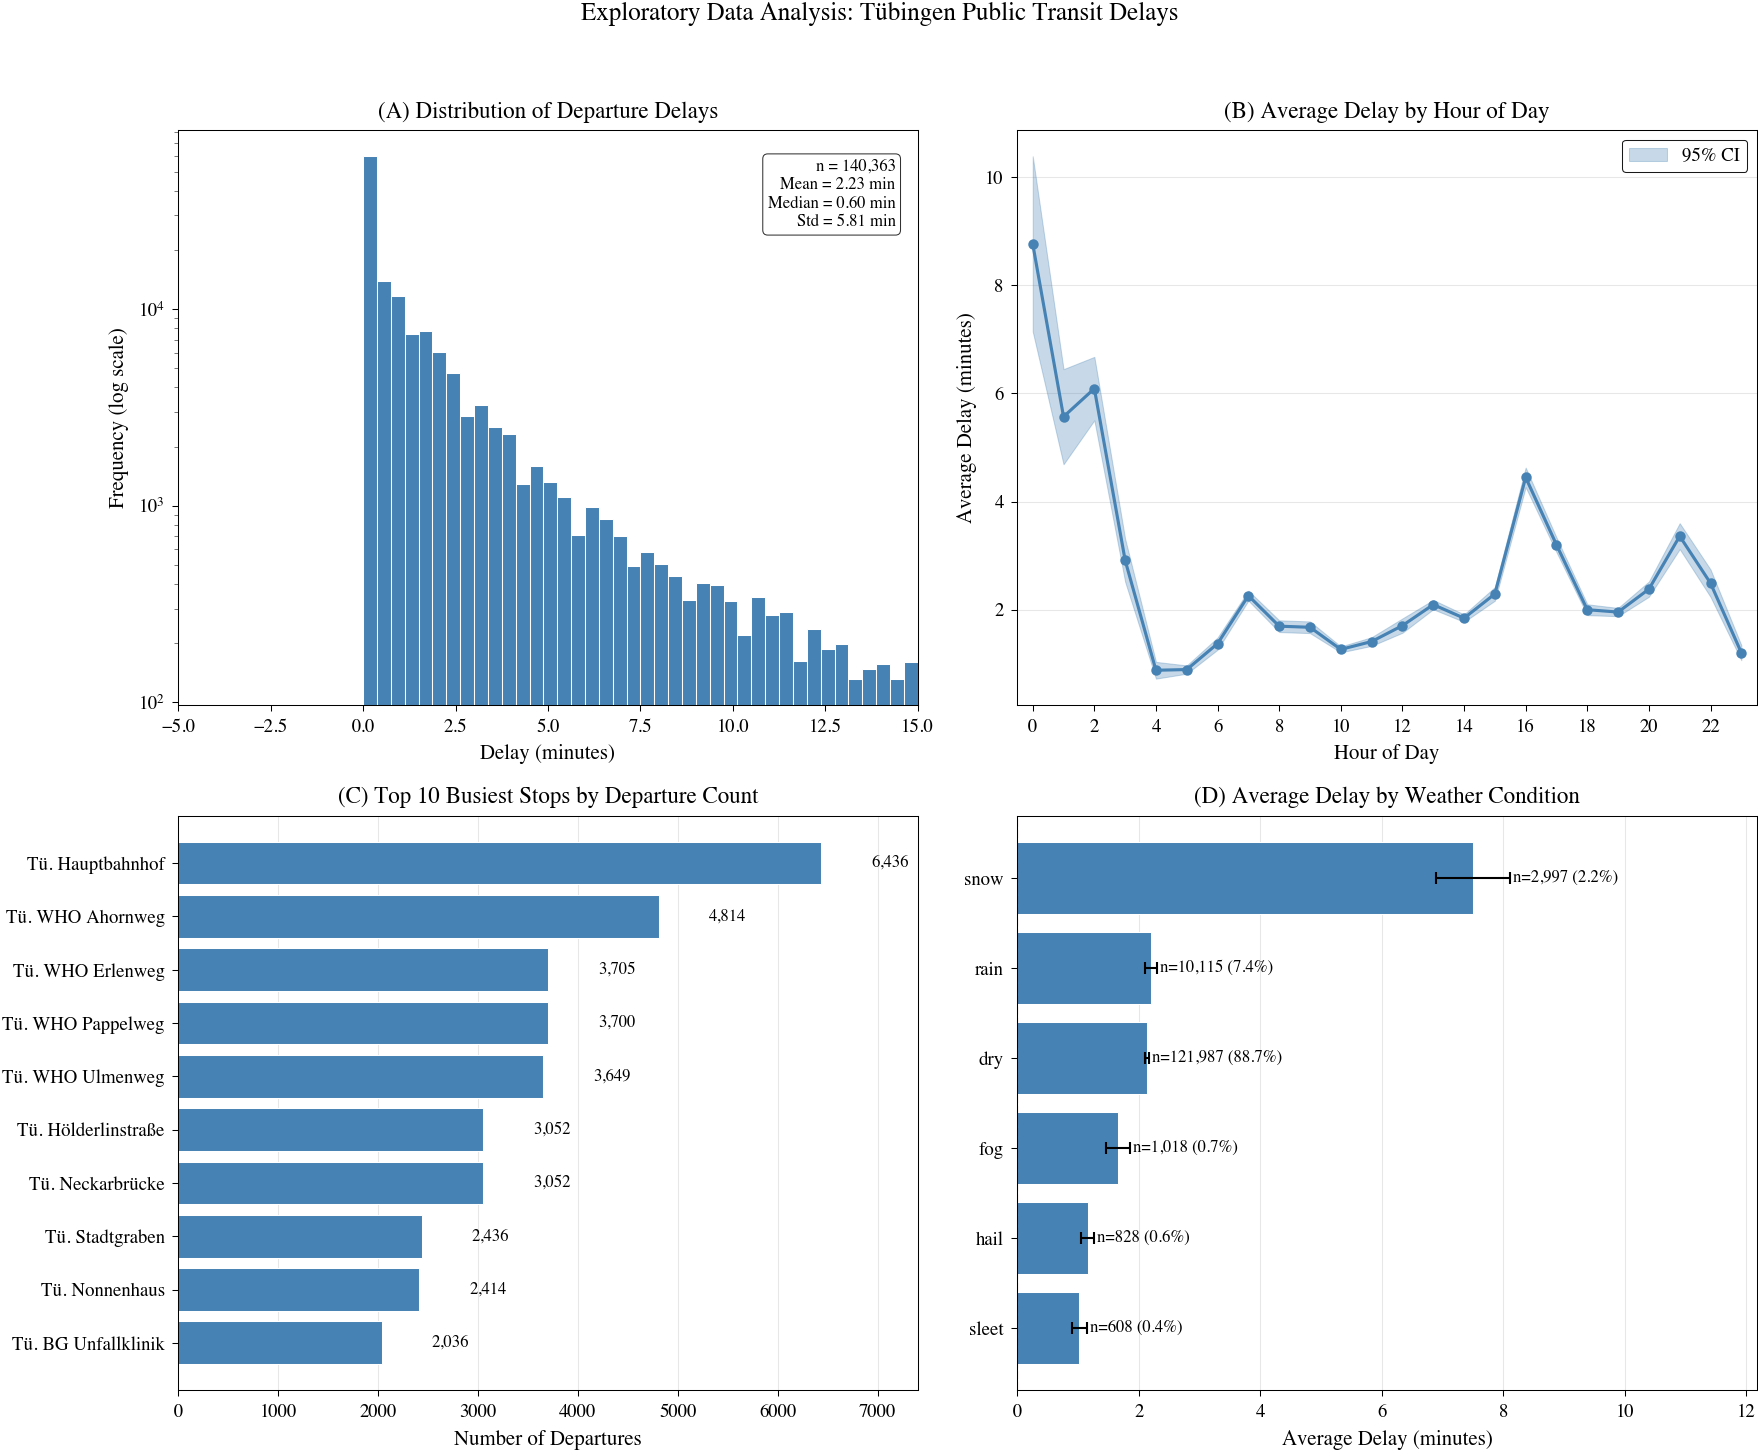

Figure saved as 'eda_4panel.png' and 'eda_4panel.pdf'


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# Academic style settings for publication-quality figures
# =============================================================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Exploratory Data Analysis: Tübingen Public Transit Delays', fontweight='bold', y=0.98)

# =============================================================================
# Panel A: Delay Distribution
# - Zoomed to -5 to 15 min where most data lies (avoids long tail distortion)
# - LOG SCALE on y-axis to show distribution shape despite high peak at 0
# =============================================================================
ax = axes[0, 0]
delays = all_departure_data['delay_minutes'].dropna()

# Focus on -5 to 15 minutes where most data lies
delays_filtered = delays[(delays >= -5) & (delays <= 15)]

# Use log scale to handle the spike at 0
ax.hist(delays_filtered, bins=40, color='steelblue', edgecolor='white', linewidth=0.5, log=True)

ax.set_title('(A) Distribution of Departure Delays', fontweight='bold')
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Frequency (log scale)')
ax.set_xlim(-5, 15)

# Summary statistics annotation
stats_text = f'n = {len(delays):,}\nMean = {delays.mean():.2f} min\nMedian = {delays.median():.2f} min\nStd = {delays.std():.2f} min'
ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# =============================================================================
# Panel B: Average Delay by Hour of Day
# - Shows 95% confidence intervals to indicate statistical uncertainty
# - Helps identify peak delay hours (rush hour effects)
# - Hypothesis: Delays increase during rush hours (7-9, 16-18)
# =============================================================================
ax = axes[0, 1]
all_departure_data['hour'] = pd.to_datetime(all_departure_data['planned_time']).dt.hour

# Calculate mean and 95% CI per hour
hourly_stats = all_departure_data.groupby('hour')['delay_minutes'].agg(['mean', 'std', 'count'])
hourly_stats['se'] = hourly_stats['std'] / np.sqrt(hourly_stats['count'])
hourly_stats['ci95'] = 1.96 * hourly_stats['se']

ax.fill_between(hourly_stats.index,
                hourly_stats['mean'] - hourly_stats['ci95'],
                hourly_stats['mean'] + hourly_stats['ci95'],
                alpha=0.3, color='steelblue', label='95% CI')
ax.plot(hourly_stats.index, hourly_stats['mean'], 'o-', color='steelblue', linewidth=1.5, markersize=4)

ax.set_title('(B) Average Delay by Hour of Day', fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Delay (minutes)')
ax.set_xticks(range(0, 24, 2))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# =============================================================================
# Panel C: Top 10 Busiest Stops
# - Shows departure frequency to understand data distribution
# - Hauptbahnhof dominates as expected (central hub)
# - Useful for understanding which stops drive aggregate statistics
# =============================================================================
ax = axes[1, 0]
stop_counts = all_departure_data['stop_name'].value_counts().head(10)

# Shorten stop names for readability (remove "Tübingen " prefix)
short_names = [name.replace('Tübingen ', 'Tü. ') for name in stop_counts.index]

bars = ax.barh(range(len(stop_counts)), stop_counts.values, color='steelblue', edgecolor='white')
ax.set_yticks(range(len(stop_counts)))
ax.set_yticklabels(short_names)
ax.invert_yaxis()

ax.set_title('(C) Top 10 Busiest Stops by Departure Count', fontweight='bold')
ax.set_xlabel('Number of Departures')
ax.set_ylabel('')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, stop_counts.values)):
    ax.text(val + 500, i, f'{val:,}', va='center', fontsize=8)

ax.set_xlim(0, stop_counts.max() * 1.15)
ax.grid(axis='x', alpha=0.3)

# =============================================================================
# Panel D: Average Delay by Weather Condition
# - Shows MEAN delay with 95% CI error bars
# - Labels placed OUTSIDE plot area to avoid overlap with bars
# - Sample sizes shown to assess reliability of estimates
# =============================================================================
ax = axes[1, 1]

# Group by weather condition and compute statistics
weather_stats = all_departure_data.groupby('condition')['delay_minutes'].agg(['mean', 'std', 'count'])
weather_stats = weather_stats[weather_stats['count'] >= 100]  # Filter conditions with <100 samples
weather_stats['se'] = weather_stats['std'] / np.sqrt(weather_stats['count'])
weather_stats['ci95'] = 1.96 * weather_stats['se']
weather_stats = weather_stats.sort_values('mean', ascending=True)

# Calculate percentage of total observations per condition
total_obs = weather_stats['count'].sum()
weather_stats['pct'] = 100 * weather_stats['count'] / total_obs

y_pos = range(len(weather_stats))
bars = ax.barh(y_pos, weather_stats['mean'], xerr=weather_stats['ci95'],
               color='steelblue', edgecolor='white', capsize=3, error_kw={'linewidth': 1})
ax.set_yticks(y_pos)
ax.set_yticklabels(weather_stats.index)

ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_title('(D) Average Delay by Weather Condition', fontweight='bold')
ax.set_xlabel('Average Delay (minutes)')
ax.set_ylabel('')
ax.grid(axis='x', alpha=0.3)

# Extend x-axis to make room for labels on the right
x_max = weather_stats['mean'].max() + weather_stats['ci95'].max()
ax.set_xlim(ax.get_xlim()[0], x_max * 1.5)

# Place labels to the RIGHT of the error bars, with clear black font
for i, (idx, row) in enumerate(weather_stats.iterrows()):
    label_x = row['mean'] + row['ci95'] + 0.05  # Position after error bar
    ax.text(label_x, i, f'n={int(row["count"]):,} ({row["pct"]:.1f}%)',
            va='center', ha='left', fontsize=8, fontweight='normal', color='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('plots/eda_4panel.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.savefig('plots/eda_4panel.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved as 'eda_4panel.png' and 'eda_4panel.pdf'")

EDA Extension 1

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/2404676608.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


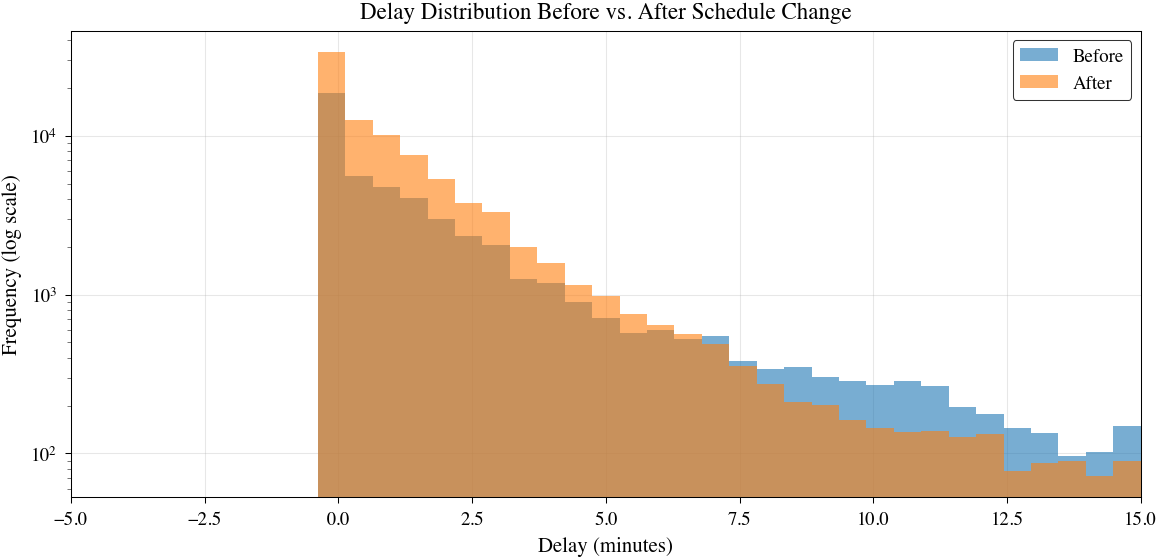

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/2404676608.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


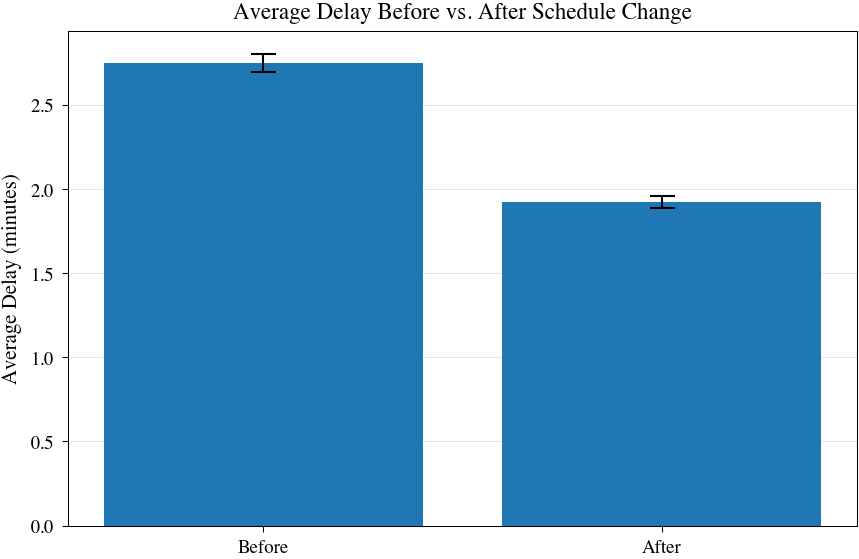

In [78]:
schedule_date = pd.Timestamp('2025-12-14')

before = all_departure_data[all_departure_data['timestamp'] < schedule_date]
after  = all_departure_data[all_departure_data['timestamp'] >= schedule_date]

# Distribution Comparison
fig, ax = plt.subplots(figsize=(8, 4))

bins = np.linspace(-5, 15, 40)

ax.hist(before['delay_minutes'], bins=bins, alpha=0.6, label='Before', log=True)
ax.hist(after['delay_minutes'],  bins=bins, alpha=0.6, label='After',  log=True)

ax.set_title('Delay Distribution Before vs. After Schedule Change', fontweight='bold')
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Frequency (log scale)')
ax.legend()
ax.set_xlim(-5, 15)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext1_schedule_change_distribution.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext1_schedule_change_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Mean delay comparison with CI
def mean_ci(x):
    return pd.Series({
        'mean': x.mean(),
        'ci95': 1.96 * x.std() / np.sqrt(len(x))
    })

compare = pd.concat([
    before['delay_minutes'].pipe(mean_ci),
    after['delay_minutes'].pipe(mean_ci)
], axis=1)

compare.columns = ['Before', 'After']

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(compare.columns, compare.loc['mean'],
       yerr=compare.loc['ci95'], capsize=6)

ax.set_ylabel('Average Delay (minutes)')
ax.set_title('Average Delay Before vs. After Schedule Change', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext1_schedule_change_mean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext1_schedule_change_mean.png', dpi=150, bbox_inches='tight')
plt.show()

EDA Extension 2

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/1046343897.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


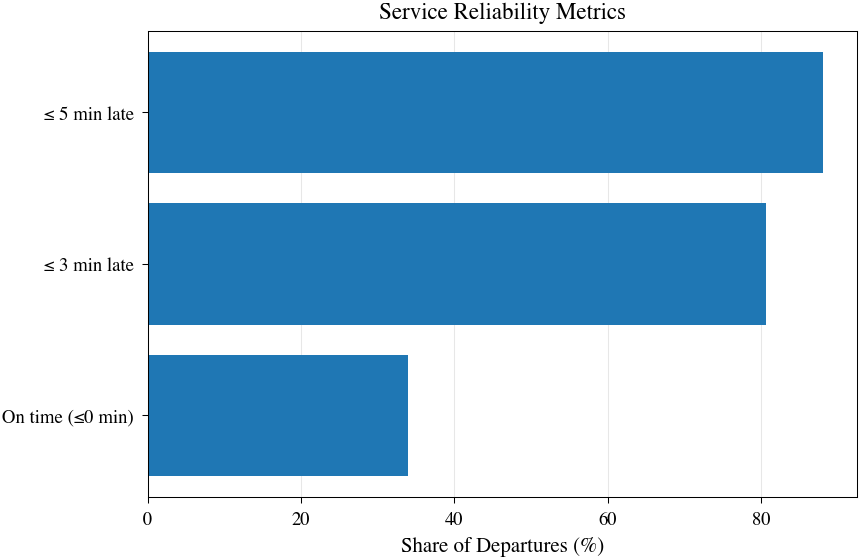

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/1046343897.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


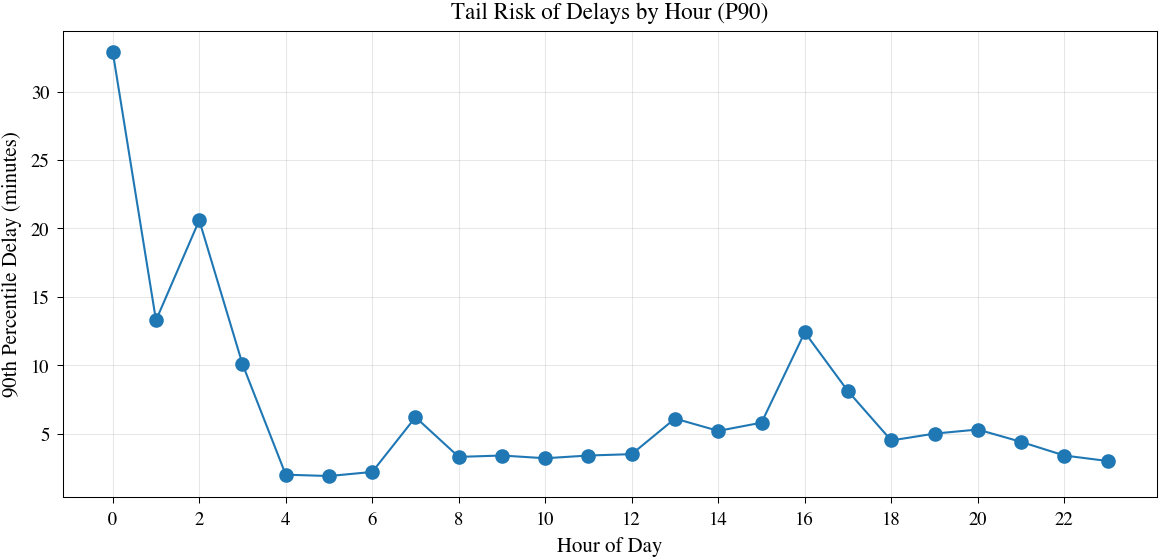

In [79]:
# On-time performance
reliability = {
    'On time (≤0 min)': (all_departure_data['delay_minutes'] <= 0).mean(),
    '≤ 3 min late':    (all_departure_data['delay_minutes'] <= 3).mean(),
    '≤ 5 min late':    (all_departure_data['delay_minutes'] <= 5).mean()
}

rel_df = pd.DataFrame.from_dict(reliability, orient='index', columns=['Share'])
rel_df['Share'] *= 100

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(rel_df.index, rel_df['Share'])
ax.set_xlabel('Share of Departures (%)')
ax.set_title('Service Reliability Metrics', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext2_reliability_metrics.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext2_reliability_metrics.png', dpi=150, bbox_inches='tight')
plt.show()


# 90th percentile delay by hour
p90_hour = all_departure_data.groupby('hour')['delay_minutes'].quantile(0.9)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(p90_hour.index, p90_hour.values, marker='o')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('90th Percentile Delay (minutes)')
ax.set_title('Tail Risk of Delays by Hour (P90)', fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext2_p90_delay_by_hour.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext2_p90_delay_by_hour.png', dpi=150, bbox_inches='tight')
plt.show()

EDA Extension 3

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/1529691177.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


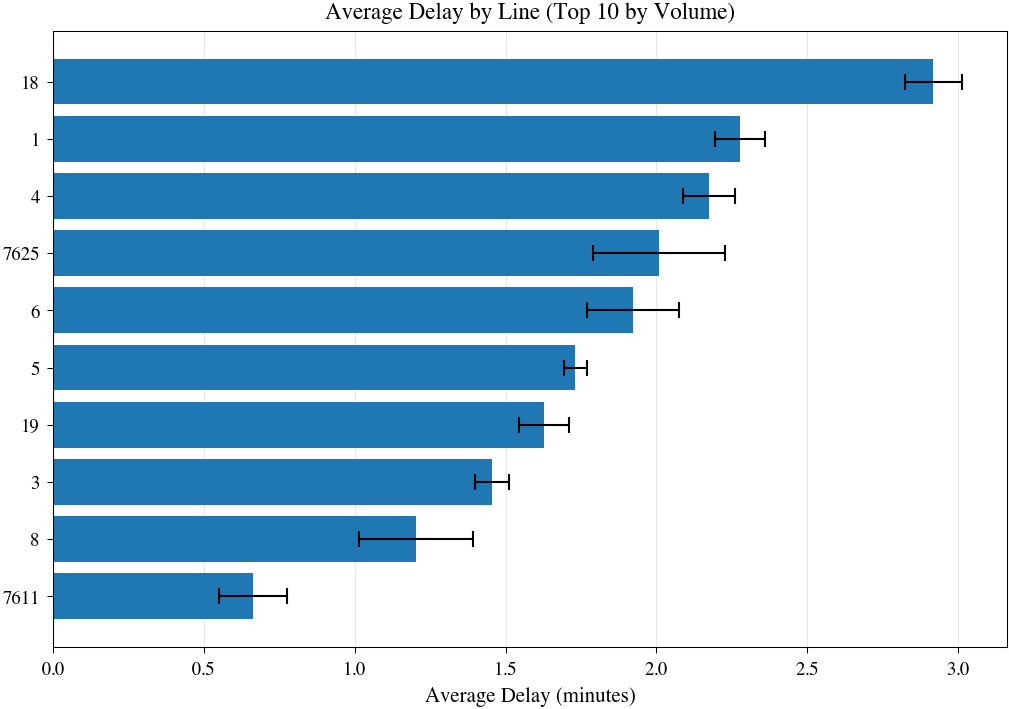

In [80]:
# Top 10 Lines by Volume
top_lines = all_departure_data['line_name'].value_counts().head(10).index
line_stats = all_departure_data[all_departure_data['line_name'].isin(top_lines)] \
    .groupby('line_name')['delay_minutes'] \
    .agg(['mean', 'std', 'count'])

line_stats['ci95'] = 1.96 * line_stats['std'] / np.sqrt(line_stats['count'])
line_stats = line_stats.sort_values('mean')

fig, ax = plt.subplots(figsize=(7, 5))

ax.barh(line_stats.index, line_stats['mean'],
        xerr=line_stats['ci95'], capsize=4)

ax.axvline(0, color='darkred', linestyle='--', linewidth=1)
ax.set_xlabel('Average Delay (minutes)')
ax.set_title('Average Delay by Line (Top 10 by Volume)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext3_delay_by_line.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext3_delay_by_line.png', dpi=150, bbox_inches='tight')
plt.show()

EDA Extension 4

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/618897187.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=30)
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/618897187.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


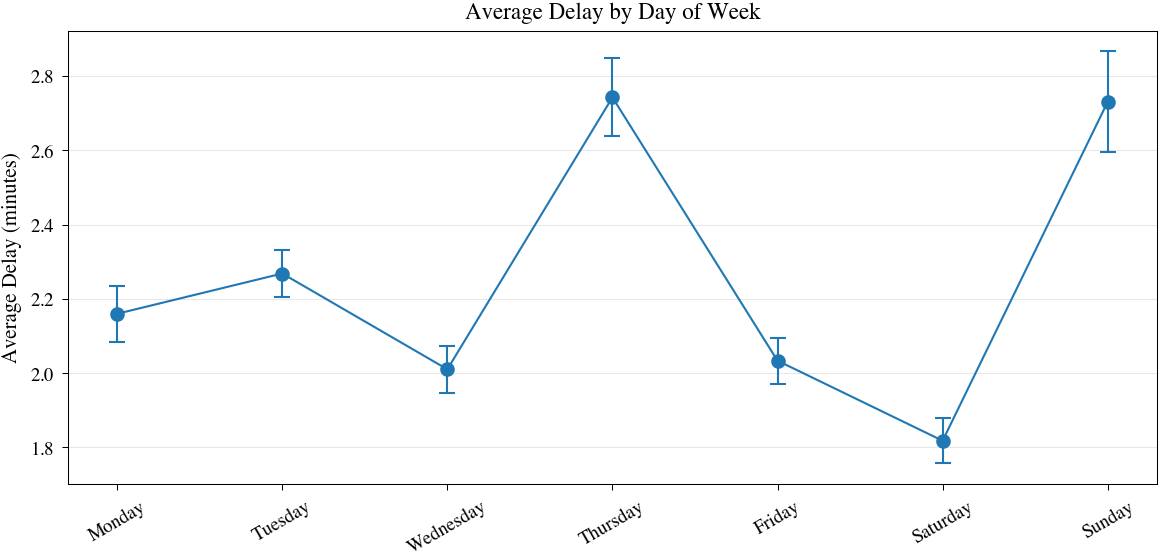

In [81]:
all_departure_data['weekday'] = all_departure_data['timestamp'].dt.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_stats = all_departure_data.groupby('weekday')['delay_minutes'] \
    .agg(['mean', 'std', 'count']).reindex(order)

weekday_stats['ci95'] = 1.96 * weekday_stats['std'] / np.sqrt(weekday_stats['count'])

fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(weekday_stats.index, weekday_stats['mean'],
            yerr=weekday_stats['ci95'], fmt='o-', capsize=4)

ax.set_ylabel('Average Delay (minutes)')
ax.set_title('Average Delay by Day of Week', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_xticklabels(order, rotation=30)

plt.tight_layout()
plt.savefig('plots/eda_ext4_delay_by_weekday.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext4_delay_by_weekday.png', dpi=150, bbox_inches='tight')
plt.show()

## Delay Accumulation Analysis (Trip Data)

Investigates whether delays accumulate as buses progress through their routes. Uses trip data with stop_sequence to analyze correlation between route position and delay magnitude.

Trip data: 143,213 rows (actual observed delays)
Stop sequence range: 1 - 38

=== DELAY BY STOP SEQUENCE ===
Correlation (stop_sequence vs delay): r = 0.1637

Sample of mean delays by stop position:
  Stop  1: mean = 1.44 min (n = 16,021)
  Stop  5: mean = 1.86 min (n = 11,212)
  Stop 10: mean = 2.18 min (n = 7,642)
  Stop 15: mean = 2.98 min (n = 3,373)
  Stop 20: mean = 7.02 min (n = 612)
  Stop 25: mean = 20.12 min (n = 100)


/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/4003655145.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


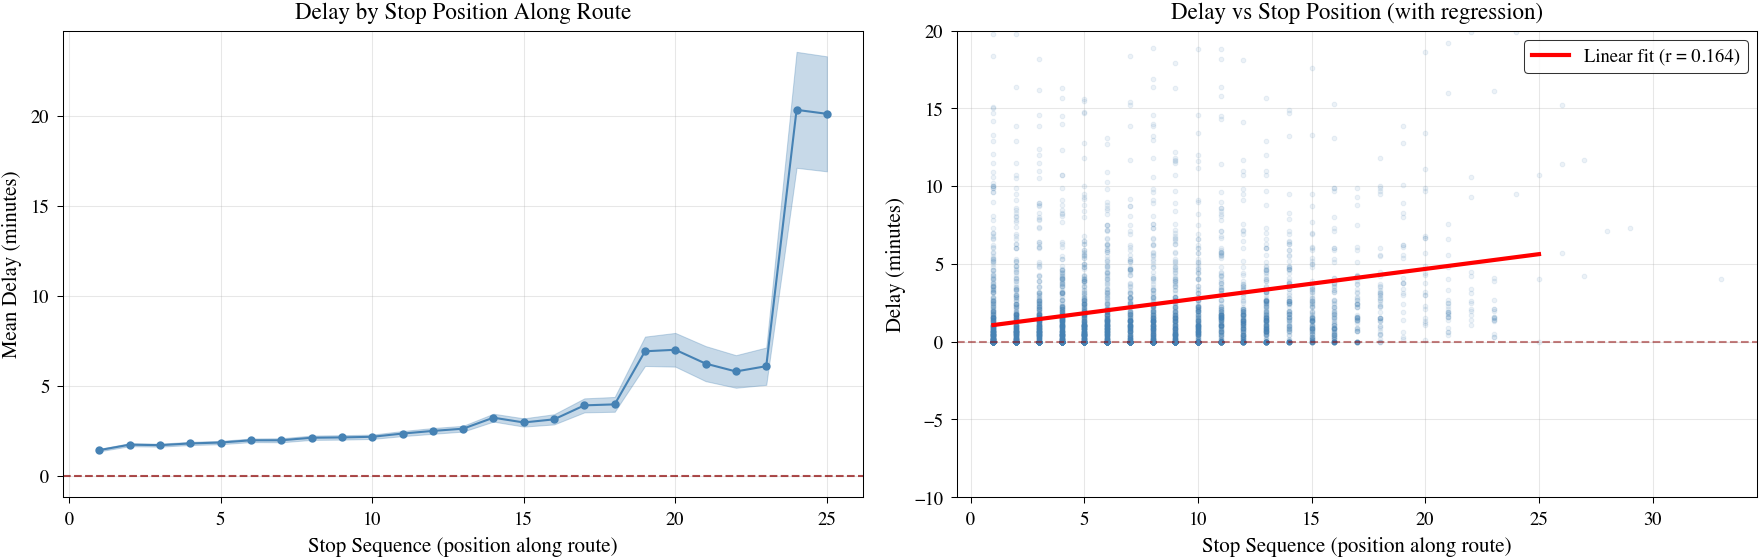


✓ Figure saved to plots/delay_accumulation_analysis.png

Conclusion: r = 0.1637 indicates weak correlation.
Delays do NOT systematically accumulate as buses progress through routes.


In [82]:
# =============================================================================
# DELAY ACCUMULATION ANALYSIS
# =============================================================================
# Question: Do delays accumulate as buses progress through their routes?
# Uses stop_sequence to analyze correlation between route position and delay magnitude.
# NOTE: Uses all_departure_data which contains actual observed delays (phase='previous')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use the already-loaded data with actual observed delays
trip_data = all_departure_data.copy()

print(f"Trip data: {len(trip_data):,} rows (actual observed delays)")
print(f"Stop sequence range: {trip_data['stop_sequence'].min()} - {trip_data['stop_sequence'].max()}")

# Analyze: does delay increase with stop_sequence?
seq_stats = trip_data.groupby('stop_sequence')['delay_minutes'].agg(['mean', 'std', 'count'])
seq_stats = seq_stats[seq_stats['count'] >= 100]  # filter small samples
seq_stats['ci95'] = 1.96 * seq_stats['std'] / np.sqrt(seq_stats['count'])

# Correlation between stop_sequence and delay
valid = trip_data[trip_data['delay_minutes'].notna() & trip_data['stop_sequence'].notna()]
corr = valid['stop_sequence'].corr(valid['delay_minutes'])

print(f"\n=== DELAY BY STOP SEQUENCE ===")
print(f"Correlation (stop_sequence vs delay): r = {corr:.4f}")
print(f"\nSample of mean delays by stop position:")
for seq in [1, 5, 10, 15, 20, 25, 30]:
    if seq in seq_stats.index:
        row = seq_stats.loc[seq]
        print(f"  Stop {seq:2d}: mean = {row['mean']:.2f} min (n = {int(row['count']):,})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Mean delay by stop sequence
ax = axes[0]
ax.fill_between(seq_stats.index, 
                seq_stats['mean'] - seq_stats['ci95'],
                seq_stats['mean'] + seq_stats['ci95'],
                alpha=0.3, color='steelblue')
ax.plot(seq_stats.index, seq_stats['mean'], 'o-', color='steelblue', markersize=3)
ax.axhline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Stop Sequence (position along route)')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('Delay by Stop Position Along Route', fontweight='bold')
ax.grid(alpha=0.3)

# Right: Scatter with regression line (sample for visibility)
ax = axes[1]
sample = valid.sample(min(5000, len(valid)), random_state=42)
ax.scatter(sample['stop_sequence'], sample['delay_minutes'],
           alpha=0.1, s=5, color='steelblue')

# Add regression line
z = np.polyfit(valid['stop_sequence'], valid['delay_minutes'], 1)
p = np.poly1d(z)
x_line = np.linspace(1, seq_stats.index.max(), 100)
ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Linear fit (r = {corr:.3f})')

ax.axhline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Stop Sequence (position along route)')
ax.set_ylabel('Delay (minutes)')
ax.set_title('Delay vs Stop Position (with regression)', fontweight='bold')
ax.set_ylim(-10, 20)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/delay_accumulation_analysis.png', dpi=150, bbox_inches='tight')
plt.savefig('plots/delay_accumulation_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to plots/delay_accumulation_analysis.png")
print(f"\nConclusion: r = {corr:.4f} indicates {'NO' if abs(corr) < 0.1 else 'weak' if abs(corr) < 0.3 else 'moderate'} correlation.")
print("Delays do NOT systematically accumulate as buses progress through routes.")

Grunddaten (EDA?)

In [83]:
# =========================
# Grunddaten: Mean, Median, CI95%
# Covers hypotheses via sensible groupings + produces a clean summary table.
# =========================

import numpy as np
import pandas as pd

df = all_departure_data.copy()

# ---- 1) Basic cleaning / preparation ----
# Ensure timestamps are datetime
for c in ["timestamp", "planned_time", "estimated_time", "weather_timestamp"]:
    if c in df.columns and not np.issubdtype(df[c].dtype, np.datetime64):
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Delay: keep only rows where delay_minutes exists
df = df[df["delay_minutes"].notna()].copy()

# Add useful time fields
df["date"] = df["timestamp"].dt.date
df["weekday"] = df["timestamp"].dt.day_name()
df["weekday_num"] = df["timestamp"].dt.weekday  # 0=Mon ... 6=Sun
df["is_weekend"] = df["weekday_num"].isin([5, 6])
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

# Hour already exists, but ensure it’s numeric
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")

# Delay variants (for Hypothesis 1 and “often late”)
df["is_late"] = df["delay_minutes"] > 0
df["delay_pos"] = df["delay_minutes"].where(df["delay_minutes"] > 0, np.nan)  # delay among late buses only

# Weather “bad weather” flags (covers Hypothesis 2)
#  - condition-based (categorical)
#  - precipitation/wind/cloud as numeric groupings
df["is_rainy"] = df["precipitation_mm"].fillna(0) > 0
df["precip_bin"] = pd.cut(
    df["precipitation_mm"].fillna(0),
    bins=[-0.001, 0, 0.5, 2, 10, np.inf],
    labels=["0", "0-0.5", "0.5-2", "2-10", "10+"]
)
df["wind_bin"] = pd.qcut(df["wind_speed_ms"].dropna(), q=4, duplicates="drop")
df["temp_bin"] = pd.qcut(df["temperature"].dropna(), q=4, duplicates="drop")
df["cloud_bin"] = pd.qcut(df["cloud_cover"].dropna(), q=4, duplicates="drop")

# Time-of-day bins (Hypothesis 4 & 6)
df["daypart"] = pd.cut(
    df["hour"],
    bins=[-0.5, 5.5, 9.5, 15.5, 19.5, 23.5],
    labels=["Nacht (0-5)", "Morgen-Peak (6-9)", "Mittag (10-15)", "Abend-Peak (16-19)", "Spät (20-23)"]
)

# Traffic proxy for Hypothesis 6: bus stop "busyness" = number of departures at stop
# (You can later combine with hour/daypart for "verkehrsreiche Tageszeit")
stop_counts = df["stop_name"].value_counts()
df["stop_busyness"] = df["stop_name"].map(stop_counts)
df["stop_busyness_bin"] = pd.qcut(df["stop_busyness"], q=4, duplicates="drop")

# ---- 2) Stats helpers: mean, median, CI95% (bootstrap, robust) ----
def bootstrap_ci(x, stat_fn=np.mean, n_boot=2000, ci=0.95, seed=42):
    """Return (low, high) bootstrap CI for a 1D array-like x."""
    x = pd.Series(x).dropna().values
    if len(x) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    stats = np.empty(n_boot, dtype=float)
    n = len(x)
    for i in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        stats[i] = stat_fn(sample)
    alpha = 1 - ci
    return (np.quantile(stats, alpha / 2), np.quantile(stats, 1 - alpha / 2))

def summarize_series(x, label):
    """Compute n, mean, median, share late, and CI95% for mean (and median via bootstrap)."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n == 0:
        return {
            "group": label,
            "n": 0,
            "mean": np.nan,
            "median": np.nan,
            "ci95_mean_low": np.nan,
            "ci95_mean_high": np.nan,
            "ci95_median_low": np.nan,
            "ci95_median_high": np.nan,
        }
    mean = x.mean()
    med = x.median()
    ci_mean = bootstrap_ci(x, stat_fn=np.mean)
    ci_med = bootstrap_ci(x, stat_fn=np.median)
    return {
        "group": label,
        "n": n,
        "mean": mean,
        "median": med,
        "ci95_mean_low": ci_mean[0],
        "ci95_mean_high": ci_mean[1],
        "ci95_median_low": ci_med[0],
        "ci95_median_high": ci_med[1],
    }

def group_summary(df_in, group_cols, value_col="delay_minutes", min_n=50, top_n=None):
    """
    Summarize delay stats by group_cols.
    - min_n filters small groups.
    - top_n keeps only top_n groups by frequency if group_cols is a single column.
    """
    d = df_in.copy()
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    if top_n is not None and len(group_cols) == 1:
        counts = d[group_cols[0]].value_counts()
        keep = counts.head(top_n).index
        d = d[d[group_cols[0]].isin(keep)]

    out = []
    for keys, g in d.groupby(group_cols, dropna=False):
        if not isinstance(keys, tuple):
            keys = (keys,)
        label = " | ".join([f"{col}={val}" for col, val in zip(group_cols, keys)])
        x = g[value_col]
        if x.notna().sum() >= min_n:
            out.append(summarize_series(x, label))
    return pd.DataFrame(out)

# ---- 3) Build summaries for hypotheses ----
tables = []

# H1: "oft" zu spät -> overall + share late + delay among all and among late only
overall_all = summarize_series(df["delay_minutes"], "OVERALL: delay_minutes (all with estimated_time)")
overall_late = summarize_series(df["delay_pos"], "OVERALL: delay_minutes (late only; delay>0)")

# Add late share and n for late
late_share = df["is_late"].mean()
n_total = df["delay_minutes"].notna().sum()
n_late = df["is_late"].sum()

overall_df = pd.DataFrame([overall_all, overall_late])
overall_df["late_share"] = [late_share, late_share]
overall_df["n_total"] = [n_total, n_total]
overall_df["n_late"] = [n_late, n_late]
tables.append(overall_df)

# H2: Weather impact
if "condition" in df.columns:
    tables.append(group_summary(df, "condition", "delay_minutes", min_n=100))
tables.append(group_summary(df, "is_rainy", "delay_minutes", min_n=200))
tables.append(group_summary(df, "precip_bin", "delay_minutes", min_n=200))
if "wind_bin" in df.columns:
    tables.append(group_summary(df, "wind_bin", "delay_minutes", min_n=200))
if "temp_bin" in df.columns:
    tables.append(group_summary(df, "temp_bin", "delay_minutes", min_n=200))
if "cloud_bin" in df.columns:
    tables.append(group_summary(df, "cloud_bin", "delay_minutes", min_n=200))

# H3: Stop dependence (top 25 stops, because otherwise too many)
tables.append(group_summary(df, "stop_name", "delay_minutes", min_n=200, top_n=25))

# H4: Delay changes over the day
tables.append(group_summary(df, "hour", "delay_minutes", min_n=200))
tables.append(group_summary(df, "daypart", "delay_minutes", min_n=200))

# H5: Delays getting larger over time (choose daily or monthly trend)
tables.append(group_summary(df, "date", "delay_minutes", min_n=100))   # daily (may be many rows)
tables.append(group_summary(df, "month", "delay_minutes", min_n=200))  # monthly trend

# H6: Local accumulation where traffic is higher (proxy: busyness quartiles, optionally by daypart)
tables.append(group_summary(df, "stop_busyness_bin", "delay_minutes", min_n=200))
tables.append(group_summary(df, ["stop_busyness_bin", "daypart"], "delay_minutes", min_n=200))

# H8: Weekend vs weekday (and by weekday name)
tables.append(group_summary(df, "is_weekend", "delay_minutes", min_n=200))
tables.append(group_summary(df, "weekday", "delay_minutes", min_n=200))

# Extra: by line and destination (often helpful for interpretation)
tables.append(group_summary(df, "line_name", "delay_minutes", min_n=200, top_n=20))
tables.append(group_summary(df, "destination", "delay_minutes", min_n=200, top_n=20))

# ---- 4) Combine into one tidy summary table ----
summary_df = pd.concat(tables, ignore_index=True)

# Add helpful sorting columns
summary_df["abs_mean"] = summary_df["mean"].abs()
summary_df = summary_df.sort_values(["n", "abs_mean"], ascending=[False, False]).drop(columns=["abs_mean"])

# ---- 5) Display + optional export ----
display(summary_df.head(30))
print(f"Total summary rows: {len(summary_df)}")

summary_df.to_csv("outputs/grunddaten_mean_median_ci95_summary.csv", index=False)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/572767097.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, g in d.groupby(group_cols, dropna=False):
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/572767097.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, g in d.groupby(group_cols, dropna=False):
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/572767097.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

,group,n,mean,median,ci95_mean_low,ci95_mean_high,ci95_median_low,ci95_median_high,late_share,n_total,n_late
0,OVERALL: delay_minutes (all with estimated_time),140363,2.228923,0.6,2.199313,2.260401,0.6,0.6,0.653883,140363.0,91781.0
9,is_rainy=False,133999,2.136670,0.6,2.106553,2.166033,0.6,0.6,NaN,NaN,NaN
11,precip_bin=0,133999,2.136670,0.6,2.106553,2.166033,0.6,0.6,NaN,NaN,NaN
2,condition=dry,121987,2.137184,0.6,2.108171,2.166153,0.6,0.6,NaN,NaN,NaN
187,is_weekend=False,103260,2.239122,0.6,2.206703,2.274178,0.6,0.6,NaN,NaN,NaN
24,"cloud_bin=(75.0, 100.0]",101987,2.456909,0.7,2.417161,2.494759,0.7,0.7,NaN,NaN,NaN
1,OVERALL: delay_minutes (late only; delay>0),91781,3.408748,1.5,3.363400,3.453933,1.5,1.5,0.653883,140363.0,91781.0
161,month=2025-12,57459,2.319604,0.6,2.272661,2.365185,0.6,0.7,NaN,NaN,NaN
162,month=2026-01,54446,2.114673,0.6,2.066186,2.167888,0.6,0.6,NaN,NaN,NaN
77,daypart=Mittag (10-15),44206,1.796521,0.7,1.757003,1.837443,0.6,0.7,NaN,NaN,NaN


Total summary rows: 236


In [84]:
# =========================
# 1) Baseline: OVERALL (all)
# =========================

baseline = summary_df[
    summary_df["group"].str.contains("OVERALL: delay_minutes (all", regex=False)
].iloc[0]

overall_mean = float(baseline["mean"])
overall_low  = float(baseline["ci95_mean_low"])
overall_high = float(baseline["ci95_mean_high"])

print(f"OVERALL mean={overall_mean:.3f}, CI95=[{overall_low:.3f}, {overall_high:.3f}]")

# =========================
# 2) Interpretation columns
# =========================

dfi = summary_df.copy()

# difference to overall
dfi["delta_mean"] = dfi["mean"] - overall_mean

# CI non-overlap logic
dfi["clearly_higher"] = dfi["ci95_mean_low"]  > overall_high
dfi["clearly_lower"]  = dfi["ci95_mean_high"] < overall_low

dfi["direction"] = np.where(
    dfi["clearly_higher"], "higher",
    np.where(dfi["clearly_lower"], "lower", "overlap")
)

# show only clearly higher OR clearly lower groups
dfi["show"] = dfi["clearly_higher"] | dfi["clearly_lower"]

# =========================
# 3) Helper: mini tables
# =========================

def mini_table(title, pattern, top=10, min_n=200):
    t = dfi[dfi["group"].str.contains(pattern, regex=True, na=False)].copy()
    t = t[~t["group"].str.contains("OVERALL:", regex=True, na=False)]
    t = t[t["n"] >= min_n]
    t = t[t["show"]]

    # show strongest higher AND strongest lower
    higher = t.sort_values("delta_mean", ascending=False).head(top)
    lower  = t.sort_values("delta_mean", ascending=True).head(top)

    t = pd.concat([higher, lower]).drop_duplicates()

    out = t[
        ["group","n","mean","ci95_mean_low","ci95_mean_high","delta_mean","direction"]
    ].copy()

    for c in ["mean","ci95_mean_low","ci95_mean_high","delta_mean"]:
        out[c] = out[c].astype(float).round(3)

    print("\n" + title)
    display(out.reset_index(drop=True))

    return out.reset_index(drop=True)

# =========================
# 4) Per-hypothesis tables
# =========================

# H2: Weather
h2 = mini_table(
    "H2 Weather (clearly different from overall)",
    pattern=r"(?:condition=|is_rainy=|precip_bin=|wind_bin=|temp_bin=|cloud_bin=)",
    top=8,
    min_n=200
)

# H3: Stops
h3 = mini_table(
    "H3 Stops (clearly different from overall)",
    pattern=r"(?:stop_name=)",
    top=8,
    min_n=200
)

# H4: Time of day
h4 = mini_table(
    "H4 Time of day (clearly different from overall)",
    pattern=r"(?:hour=|daypart=)",
    top=8,
    min_n=200
)

# H5: Trend over time (months)
h5 = mini_table(
    "H5 Trend over time (months, descriptive)",
    pattern=r"(?:month=)",
    top=8,
    min_n=200
)

# H6: Busy-area proxy
h6 = mini_table(
    "H6 Busy-area proxy (clearly different from overall)",
    pattern=r"(?:stop_busyness_bin=)",
    top=8,
    min_n=200
)

# H8: Weekend
h8 = mini_table(
    "H8 Weekend vs weekday (clearly different from overall)",
    pattern=r"(?:is_weekend=|weekday=)",
    top=8,
    min_n=200
)

# =========================
# 5) One slide-ready summary
# =========================

top = dfi[dfi["show"]].copy()
top = top[~top["group"].str.contains("OVERALL:", regex=True, na=False)]
top = top.sort_values("delta_mean", ascending=False).head(15)

top_out = top[
    ["group","n","mean","ci95_mean_low","ci95_mean_high","delta_mean","direction"]
].copy()

for c in ["mean","ci95_mean_low","ci95_mean_high","delta_mean"]:
    top_out[c] = top_out[c].astype(float).round(3)

print("\nTop findings (all groupings):")
display(top_out.reset_index(drop=True))

OVERALL mean=2.229, CI95=[2.199, 2.260]

H2 Weather (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,condition=snow,2997,7.503,6.914,8.136,5.274,higher
1,precip_bin=0.5-2,2932,6.099,5.587,6.616,3.870,higher
2,is_rainy=True,6364,4.171,3.915,4.444,1.942,higher
3,"temp_bin=(5.8, 19.1]",34693,2.542,2.484,2.600,0.313,higher
4,precip_bin=0-0.5,3308,2.465,2.333,2.604,0.236,higher
5,"cloud_bin=(75.0, 100.0]",101987,2.457,2.417,2.495,0.228,higher
6,"wind_bin=(-0.001, 6.1]",34543,2.452,2.379,2.524,0.223,higher
7,"temp_bin=(2.5, 5.8]",34921,2.152,2.104,2.198,-0.077,lower
8,condition=sleet,608,1.023,0.913,1.152,-1.206,lower
9,condition=hail,828,1.158,1.047,1.266,-1.071,lower



H3 Stops (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,stop_name=Tübingen Neckarbrücke,3046,4.533,4.270,4.818,2.304,higher
1,stop_name=Tübingen Nonnenhaus,2411,3.801,3.557,4.070,1.572,higher
2,stop_name=Tübingen Stadtgraben,2433,3.460,3.219,3.719,1.231,higher
3,stop_name=Tübingen Hauptbahnhof,6137,3.112,2.938,3.294,0.883,higher
4,stop_name=Tübingen Mohlstraße,1275,3.108,2.731,3.507,0.879,higher
5,stop_name=Tübingen Poststraße,1587,2.760,2.498,3.037,0.531,higher
6,stop_name=Tübingen Hölderlinstraße,3049,2.627,2.432,2.836,0.398,higher
7,stop_name=Tübingen Uni-Kliniken Berg,2032,2.037,1.886,2.198,-0.192,lower
8,stop_name=Tübingen WHO Ulmenweg,3639,1.113,1.021,1.217,-1.116,lower
9,stop_name=Tübingen WHO Ahornweg,4806,1.159,1.069,1.261,-1.070,lower



H4 Time of day (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,hour=0.0,360,8.764,7.223,10.406,6.535,higher
1,hour=2.0,1028,6.089,5.499,6.681,3.860,higher
2,hour=1.0,737,5.568,4.736,6.484,3.339,higher
3,hour=16.0,8375,4.446,4.264,4.636,2.217,higher
4,"stop_busyness_bin=(0.999, 610.0] | daypart=Nac...",2057,3.994,3.617,4.383,1.765,higher
5,"stop_busyness_bin=(0.999, 610.0] | daypart=Spä...",3958,3.781,3.466,4.121,1.552,higher
6,"stop_busyness_bin=(0.999, 610.0] | daypart=Abe...",10673,3.607,3.462,3.746,1.378,higher
7,hour=21.0,7206,3.359,3.126,3.609,1.130,higher
8,hour=4.0,1000,0.879,0.737,1.037,-1.350,lower
9,hour=5.0,5540,0.892,0.821,0.974,-1.337,lower



H5 Trend over time (months, descriptive)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,month=2025-12,57459,2.320,2.273,2.365,0.091,higher
1,month=2026-01,54446,2.115,2.066,2.168,-0.114,lower



H6 Busy-area proxy (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,"stop_busyness_bin=(0.999, 610.0] | daypart=Nac...",2057,3.994,3.617,4.383,1.765,higher
1,"stop_busyness_bin=(0.999, 610.0] | daypart=Spä...",3958,3.781,3.466,4.121,1.552,higher
2,"stop_busyness_bin=(0.999, 610.0] | daypart=Abe...",10673,3.607,3.462,3.746,1.378,higher
3,"stop_busyness_bin=(0.999, 610.0]",35112,3.010,2.928,3.096,0.781,higher
4,"stop_busyness_bin=(2029.0, 6137.0] | daypart=A...",8941,3.004,2.875,3.130,0.776,higher
5,"stop_busyness_bin=(610.0, 892.0] | daypart=Spä...",4038,2.867,2.562,3.140,0.638,higher
6,"stop_busyness_bin=(2029.0, 6137.0] | daypart=S...",6116,2.554,2.383,2.736,0.325,higher
7,"stop_busyness_bin=(0.999, 610.0] | daypart=Mor...",7632,2.463,2.326,2.596,0.234,higher
8,"stop_busyness_bin=(610.0, 892.0] | daypart=Mor...",7701,1.051,0.974,1.135,-1.178,lower
9,"stop_busyness_bin=(610.0, 892.0] | daypart=Mit...",11784,1.363,1.295,1.434,-0.866,lower



H8 Weekend vs weekday (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,weekday=Thursday,19923,2.743,2.638,2.850,0.514,higher
1,weekday=Sunday,15542,2.731,2.600,2.863,0.502,higher
2,weekday=Friday,20415,2.034,1.970,2.097,-0.195,lower
3,weekday=Wednesday,21389,2.011,1.949,2.076,-0.218,lower
4,weekday=Saturday,21561,1.818,1.756,1.879,-0.411,lower



Top findings (all groupings):


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,date=2026-01-25,1856,10.166,9.221,11.123,7.937,higher
1,line_name=21,1106,9.587,8.741,10.528,7.358,higher
2,line_name=N88,881,9.458,8.806,10.139,7.230,higher
3,hour=0.0,360,8.764,7.223,10.406,6.535,higher
4,destination=Tübingen Hagellocher Weg,671,8.438,7.948,8.922,6.210,higher
5,line_name=16,1428,8.087,7.794,8.408,5.859,higher
6,condition=snow,2997,7.503,6.914,8.136,5.274,higher
7,destination=Tübingen Egeriaplatz,721,7.202,6.183,8.329,4.973,higher
8,line_name=9,518,6.274,5.630,6.964,4.045,higher
9,precip_bin=0.5-2,2932,6.099,5.587,6.616,3.870,higher


## Network Graph

In [85]:
all_trip_data = download_and_combine_data(trip_files)
print(f"Loaded {len(all_trip_data)} trip-call rows from {len(trip_files)} files.")

Processing 1619 files in parallel (max_workers=20)...
Processed 100/1619 files...
Processed 200/1619 files...
Processed 300/1619 files...
Processed 400/1619 files...
Processed 500/1619 files...
Processed 600/1619 files...
Processed 700/1619 files...
Processed 800/1619 files...
Processed 900/1619 files...
Processed 1000/1619 files...
Processed 1100/1619 files...
Processed 1200/1619 files...
Processed 1300/1619 files...
Processed 1400/1619 files...
Processed 1500/1619 files...
Processed 1600/1619 files...
Processed 1619/1619 files...

Combined 1619 files into DataFrame with 2113390 rows.
Date range: 2025-11-11 17:00:32 to 2026-01-29 17:00:34
Loaded 2113390 trip-call rows from 1619 files.


In [86]:
# =============================================================================
# TRIP DATA REFERENCE (for cells that need raw trip structure)
# =============================================================================
# NOTE: The main analysis data (all_departure_data) is already filtered in cell 11:
#   - phase='previous' only (actual observed delays)
#   - deduplicated by journey/day/stop
#   - train lines removed (if FILTER_TRAINS=True)
#   - outliers removed (if FILTER_DELAY_OUTLIERS=True)
#
# For analyses that need the raw trip data structure (e.g., network graphs),
# we create a reference to all_departure_data which has the same columns.

all_trip_data = all_departure_data.copy()

print(f"✓ all_trip_data = all_departure_data (actual observed delays)")
print(f"  Rows: {len(all_trip_data):,}")
print(f"  Date range: {all_trip_data['timestamp'].min()} to {all_trip_data['timestamp'].max()}")
print(f"  Unique lines: {all_trip_data['line_name'].nunique()}")

✓ all_trip_data = all_departure_data (actual observed delays)
  Rows: 143,213
  Date range: 2025-11-11 17:00:32 to 2026-01-29 17:00:34
  Unique lines: 51


In [87]:
# Print data
display(all_trip_data.head(10))

,phase,stop_point_ref,stop_name,stop_sequence,platform,arrival_planned,arrival_estimated,departure_planned,departure_estimated,arrival_delay_minutes,...,wind_direction_deg,cloud_cover,pressure_hpa,relative_humidity,condition,icon,weather_source_id,weather_station_name,hour,weekday
0,previous,de:08416:3256:0:2,Oberndorf Rottenburger Str.,2,NaN,2026-01-29 17:48:00,2026-01-29 17:48:00,2026-01-29 17:48:00,2026-01-29 17:48:00,0.0,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
1,previous,de:08416:10518:0:4,Tübingen Poststraße,10,NaN,2026-01-29 17:59:24,2026-01-29 18:04:00,2026-01-29 17:59:24,2026-01-29 18:04:00,4.6,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
2,previous,de:08416:13050:0:4,Kilchberg Keltengrab,6,NaN,2026-01-29 17:48:00,2026-01-29 18:04:54,2026-01-29 17:48:00,2026-01-29 18:04:54,16.9,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
3,previous,de:08416:10907:0:4,Weilheim Rathaus,7,NaN,2026-01-29 17:51:00,2026-01-29 18:07:54,2026-01-29 17:51:00,2026-01-29 18:07:54,16.9,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
4,previous,de:08416:10213:0:4,Tübingen WHO Ahornweg,4,NaN,2026-01-29 17:43:00,2026-01-29 17:43:00,2026-01-29 17:43:00,2026-01-29 17:43:00,0.0,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
5,previous,de:08416:10212:0:4,Tübingen WHO Erlenweg,3,NaN,2026-01-29 17:41:48,2026-01-29 17:41:48,2026-01-29 17:41:48,2026-01-29 17:41:48,0.0,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
6,previous,de:08416:10211:0:4,Tübingen WHO Pappelweg,2,NaN,2026-01-29 17:40:54,2026-01-29 17:40:54,2026-01-29 17:40:54,2026-01-29 17:40:54,0.0,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
7,previous,de:08416:10260:0:4,Tübingen WHO Ulmenweg,1,NaN,NaN,NaN,2026-01-29 17:40:00,2026-01-29 17:40:00,NaN,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
8,previous,de:08416:10901:0:4,Tübingen Hechinger Straße,9,NaN,2026-01-29 17:57:00,2026-01-29 18:01:12,2026-01-29 17:57:00,2026-01-29 18:01:12,4.2,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday
9,previous,de:08416:10723:0:4,Tübingen Nelkenweg,1,NaN,NaN,NaN,2026-01-29 17:47:00,2026-01-29 17:52:30,NaN,...,130.0,100.0,1001.1,96,rain,cloudy,64012,Rottenburg-Kiebingen,17.0,Thursday


Join coordinates into trip data and fetch missing from TRIAS api

In [88]:
from trias import TriasClient

# =============================================================================
# STEP 1: Discover stops via multi-center TRIAS queries
# =============================================================================
# The TRIAS API returns ~14 stops per request. By querying from multiple centers
# (existing stops with known coordinates), we can discover more stops.

trias_client = TriasClient(requestor_ref="SeBaSTiaN_BoeHLeR")

# Get initial centers from departure data
initial_centers = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_id', as_index=False)
    .agg({'latitude': 'first', 'longitude': 'first', 'stop_name': 'first'})
    .head(20)  # Start with 20 centers
)

print(f"Discovering stops using {len(initial_centers)} initial centers...")

discovered_stops = {}  # stop_id -> {stop_id, stop_name, latitude, longitude}
processed_centers = set()

def discover_from_center(lat, lon, radius_km=3):
    """Fetch stops from TRIAS API using given center coordinates."""
    try:
        stops = trias_client.fetch_stops(center=(lat, lon), radius_km=radius_km, max_results=200)
        return stops
    except Exception:
        return pd.DataFrame()

# Initial discovery from departure data centers
for _, row in initial_centers.iterrows():
    stops = discover_from_center(row['latitude'], row['longitude'])
    for _, s in stops.iterrows():
        if s['stop_id'] not in discovered_stops:
            discovered_stops[s['stop_id']] = {
                'stop_id': s['stop_id'],
                'stop_name': s.get('stop_name'),
                'latitude': s.get('latitude'),
                'longitude': s.get('longitude'),
            }
    processed_centers.add(row['stop_id'])

print(f"After initial discovery: {len(discovered_stops)} stops")

# Iterative expansion: use newly discovered stops as centers
for iteration in range(3):
    new_centers = [
        s for sid, s in discovered_stops.items()
        if sid not in processed_centers
        and pd.notna(s.get('latitude'))
        and pd.notna(s.get('longitude'))
    ]

    if not new_centers:
        break

    new_discoveries = 0
    for stop in new_centers[:15]:  # Limit API calls per iteration
        processed_centers.add(stop['stop_id'])
        stops = discover_from_center(stop['latitude'], stop['longitude'])
        for _, s in stops.iterrows():
            if s['stop_id'] not in discovered_stops:
                discovered_stops[s['stop_id']] = {
                    'stop_id': s['stop_id'],
                    'stop_name': s.get('stop_name'),
                    'latitude': s.get('latitude'),
                    'longitude': s.get('longitude'),
                }
                new_discoveries += 1

    print(f"Iteration {iteration + 1}: +{new_discoveries} stops, total: {len(discovered_stops)}")
    if new_discoveries == 0:
        break

# Create DataFrame of discovered stops
trias_stops_df = pd.DataFrame(discovered_stops.values())
print(f"\nTotal discovered stops with coordinates: {len(trias_stops_df)}")

# =============================================================================
# STEP 2: Join coordinates from multiple sources onto trip data
# =============================================================================

# Source 1: Departure data coordinates (by stop_point_ref)
dep_coords_ref = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_point_ref', as_index=False)[['latitude', 'longitude']]
    .mean()
)

# Source 2: Departure data coordinates (by stop_name as fallback)
dep_coords_name = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_name', as_index=False)[['latitude', 'longitude']]
    .mean()
)

# Source 3: TRIAS discovered stops (by stop_id - base ID without platform suffix)
trias_coords = (
    trias_stops_df
    .dropna(subset=['latitude', 'longitude'])
    .rename(columns={'latitude': 'lat_trias', 'longitude': 'lon_trias'})
)

# Drop any existing coordinate columns
for col in ['latitude', 'longitude']:
    if col in all_trip_data.columns:
        all_trip_data = all_trip_data.drop(columns=[col])

# Extract base stop_id from stop_point_ref for TRIAS matching
# stop_point_ref like "de:08416:10044:0:1" -> stop_id "de:08416:10044"
all_trip_data['stop_id_base'] = all_trip_data['stop_point_ref'].str.extract(r'^(de:\d+:\d+)')[0]

# Join 1: From departure data by stop_point_ref
all_trip_data = all_trip_data.merge(dep_coords_ref, on='stop_point_ref', how='left')

# Join 2: From TRIAS by base stop_id
all_trip_data = all_trip_data.merge(
    trias_coords[['stop_id', 'lat_trias', 'lon_trias']],
    left_on='stop_id_base',
    right_on='stop_id',
    how='left'
)

# Fill missing coords from TRIAS
all_trip_data['latitude'] = all_trip_data['latitude'].fillna(all_trip_data['lat_trias'])
all_trip_data['longitude'] = all_trip_data['longitude'].fillna(all_trip_data['lon_trias'])

# Join 3: Fallback by stop_name
missing_mask = all_trip_data['latitude'].isna() | all_trip_data['longitude'].isna()
if missing_mask.any():
    fallback = (
        all_trip_data[missing_mask]
        .merge(dep_coords_name, on='stop_name', how='left', suffixes=('', '_fb'))
    )
    all_trip_data.loc[missing_mask, 'latitude'] = fallback['latitude_fb'].values
    all_trip_data.loc[missing_mask, 'longitude'] = fallback['longitude_fb'].values

# Clean up temporary columns
all_trip_data = all_trip_data.drop(columns=['stop_id_base', 'stop_id', 'lat_trias', 'lon_trias'], errors='ignore')

# Report coverage
stops_total = all_trip_data['stop_point_ref'].nunique()
stops_with_coords = all_trip_data[
    all_trip_data['latitude'].notna() & all_trip_data['longitude'].notna()
]['stop_point_ref'].nunique()

print(f"\nCoordinate coverage: {stops_with_coords}/{stops_total} unique stops ({100*stops_with_coords/stops_total:.1f}%)")

Discovering stops using 20 initial centers...
After initial discovery: 95 stops
Iteration 1: +44 stops, total: 139
Iteration 2: +21 stops, total: 160
Iteration 3: +12 stops, total: 172

Total discovered stops with coordinates: 172

Coordinate coverage: 182/565 unique stops (32.2%)


In [89]:
# Export filtered trip data with actual observed delays
# This parquet file is used by downstream scripts (fig2_schedule_change.py, etc.)
# Contains only phase=="previous" stops (actual observed delays), deduplicated

# Use all_departure_data which has the filtered/deduped trip data with actual delays
all_departure_data.to_parquet("outputs/all_trip_data.parquet", index=False)
print(f"Exported {len(all_departure_data):,} records with ACTUAL OBSERVED DELAYS to outputs/all_trip_data.parquet")
print(f"  (filtered for phase=='previous', deduplicated by journey/day/stop)")

Exported 143,213 records with ACTUAL OBSERVED DELAYS to outputs/all_trip_data.parquet
  (filtered for phase=='previous', deduplicated by journey/day/stop)


# Academic Hypothesis Plots

Publication-quality figures for the Data Literacy course paper. Each plot addresses a specific hypothesis from the meeting notes, following course guidelines:
- **Estimators + Confidence Intervals** over p-values
- **DKW bands** for ECDFs
- **Bootstrap CIs** for medians and percentiles
- Clear annotations with interpretable metrics

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/4143149773.py:88: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


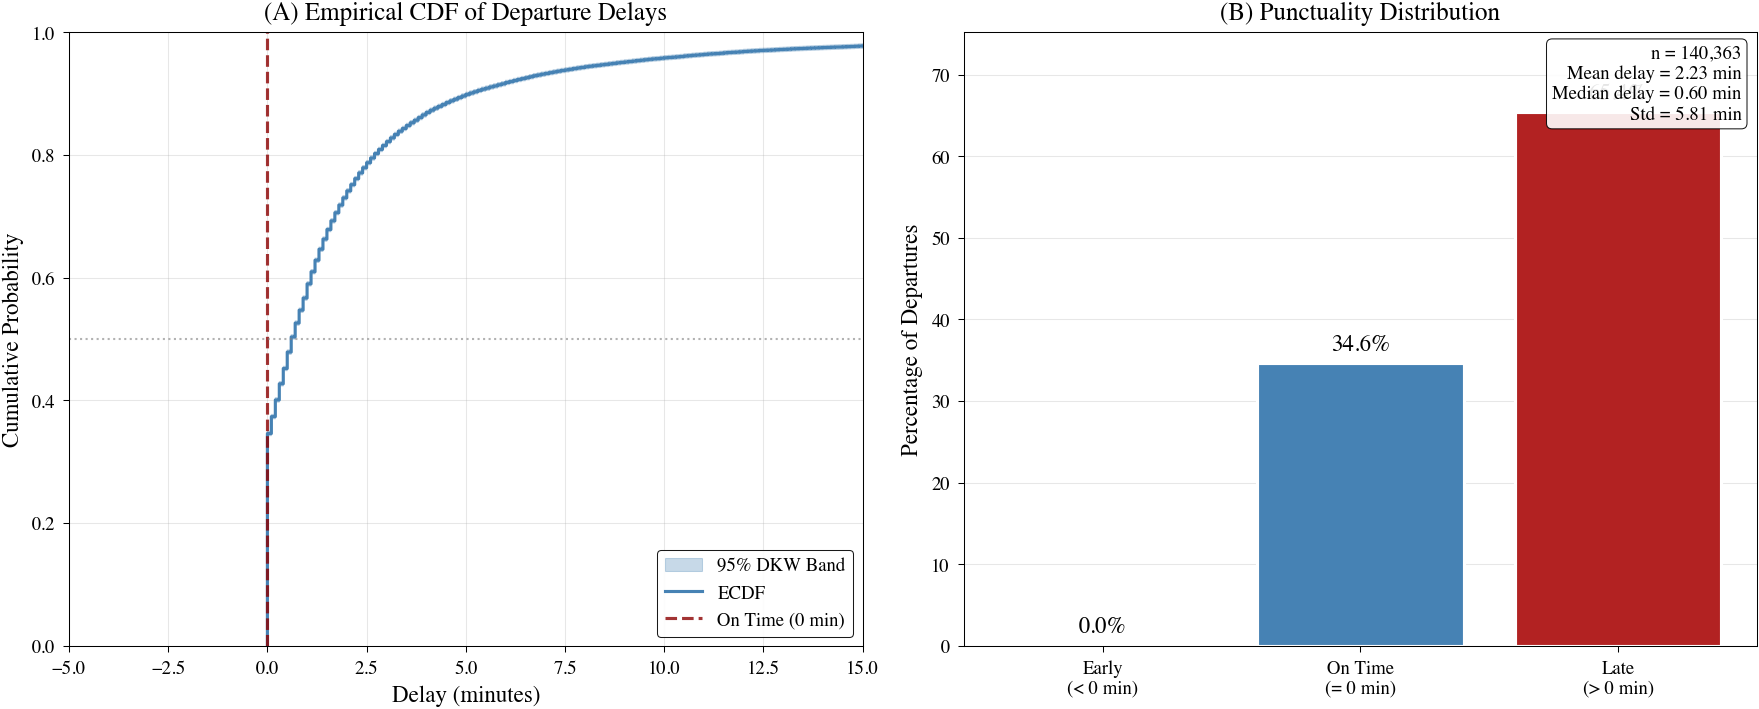


HYPOTHESIS 1 SUMMARY: Are Tübingen buses often late?
  Total observations: 140,363
  Late rate (delay > 0): 65.4%
  On-time rate (delay = 0): 34.6%
  Early rate (delay < 0): 0.0%
  Mean delay: 2.23 min
  Median delay: 0.60 min


In [90]:
# =============================================================================
# HYPOTHESIS 1: "Tübinger Busse sind oft zu spät"
# Figure: ECDF with DKW confidence bands + key metrics annotated
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Academic style
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Get delay data
delays = all_departure_data['delay_minutes'].dropna().values

# --- Panel A: ECDF with DKW confidence bands ---
ax = axes[0]

# Sort delays for ECDF
x_sorted = np.sort(delays)
n = len(x_sorted)
ecdf_y = np.arange(1, n + 1) / n

# DKW confidence bands (95%)
alpha = 0.05
epsilon = np.sqrt(np.log(2 / alpha) / (2 * n))
lower = np.clip(ecdf_y - epsilon, 0, 1)
upper = np.clip(ecdf_y + epsilon, 0, 1)

# Plot ECDF with bands
ax.fill_between(x_sorted, lower, upper, alpha=0.3, color='steelblue', label='95% DKW Band')
ax.step(x_sorted, ecdf_y, where='post', color='steelblue', linewidth=1.5, label='ECDF')

# Mark key thresholds
ax.axvline(0, color='darkred', linestyle='--', linewidth=1.5, alpha=0.8, label='On Time (0 min)')
ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.6)

# Annotate late rate
late_rate = np.mean(delays > 0)
on_time_rate = np.mean(delays == 0)
early_rate = np.mean(delays < 0)

ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('(A) Empirical CDF of Departure Delays', fontweight='bold')
ax.set_xlim(-5, 15)
ax.set_ylim(0, 1.0)  # Full range from 0 to 1 for actual observed delays
ax.legend(loc='lower right', framealpha=0.9)
ax.grid(alpha=0.3)

# --- Panel B: Summary statistics ---
ax = axes[1]

# Create summary bar chart
categories = ['Early\n(< 0 min)', 'On Time\n(= 0 min)', 'Late\n(> 0 min)']
values = [early_rate * 100, on_time_rate * 100, late_rate * 100]
colors = ['forestgreen', 'steelblue', 'firebrick']

bars = ax.bar(categories, values, color=colors, edgecolor='white', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Percentage of Departures')
ax.set_title('(B) Punctuality Distribution', fontweight='bold')
ax.set_ylim(0, max(values) * 1.15)
ax.grid(axis='y', alpha=0.3)

# Add summary stats text box
stats_text = (f'n = {n:,}\n'
              f'Mean delay = {np.mean(delays):.2f} min\n'
              f'Median delay = {np.median(delays):.2f} min\n'
              f'Std = {np.std(delays):.2f} min')
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig('plots/fig1_hypothesis1_delay_ecdf.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig1_hypothesis1_delay_ecdf.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 1 SUMMARY: Are Tübingen buses often late?")
print("="*70)
print(f"  Total observations: {n:,}")
print(f"  Late rate (delay > 0): {100*late_rate:.1f}%")
print(f"  On-time rate (delay = 0): {100*on_time_rate:.1f}%")
print(f"  Early rate (delay < 0): {100*early_rate:.1f}%")
print(f"  Mean delay: {np.mean(delays):.2f} min")
print(f"  Median delay: {np.median(delays):.2f} min")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/3112708631.py:88: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


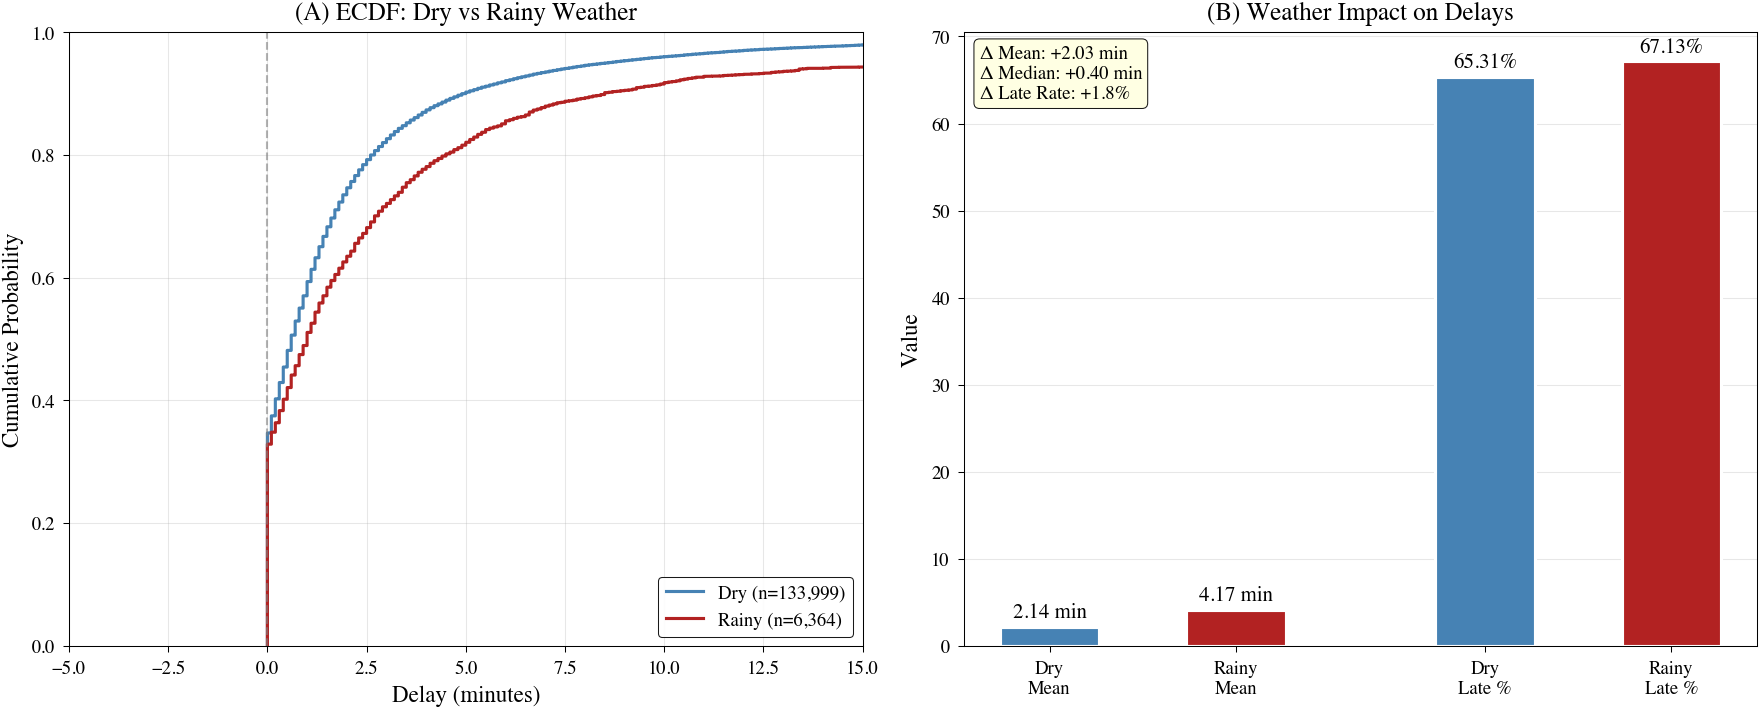


HYPOTHESIS 2 SUMMARY: Are delays larger in bad weather?
  Dry weather:  n=133,999, mean=2.14 min, median=0.60 min, late=65.3%
  Rainy weather: n=6,364, mean=4.17 min, median=1.00 min, late=67.1%
  Difference: Δmean=+2.03 min, Δmedian=+0.40 min, Δlate=+1.8%


In [91]:
# =============================================================================
# HYPOTHESIS 2: "Verspätung ist größer bei schlechtem Wetter"
# Figure: ECDF comparison dry vs rainy with DKW bands + effect size
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define weather groups: dry vs rainy (precipitation > 0)
df = all_departure_data.copy()
df['is_rainy'] = df['precipitation_mm'] > 0

delays_dry = df.loc[~df['is_rainy'], 'delay_minutes'].dropna().values
delays_rainy = df.loc[df['is_rainy'], 'delay_minutes'].dropna().values

# --- Panel A: ECDF comparison ---
ax = axes[0]

for delays, label, color in [(delays_dry, 'Dry', 'steelblue'),
                              (delays_rainy, 'Rainy', 'firebrick')]:
    x_sorted = np.sort(delays)
    n = len(x_sorted)
    ecdf_y = np.arange(1, n + 1) / n
    ax.step(x_sorted, ecdf_y, where='post', color=color, linewidth=1.5, label=f'{label} (n={n:,})')

ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.6)
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('(A) ECDF: Dry vs Rainy Weather', fontweight='bold')
ax.set_xlim(-5, 15)
ax.set_ylim(0, 1.0)  # Full range from 0 to 1 for actual observed delays
ax.legend(loc='lower right', framealpha=0.9)
ax.grid(alpha=0.3)

# --- Panel B: Summary comparison (using MEAN since median is often 0) ---
ax = axes[1]

# Calculate statistics
stats = {
    'Dry': {
        'mean': np.mean(delays_dry),
        'median': np.median(delays_dry),
        'late_rate': np.mean(delays_dry > 0),
        'n': len(delays_dry)
    },
    'Rainy': {
        'mean': np.mean(delays_rainy),
        'median': np.median(delays_rainy),
        'late_rate': np.mean(delays_rainy > 0),
        'n': len(delays_rainy)
    }
}

# Bar chart comparing mean delay and late rate
x_pos = np.array([0, 1.5, 3.5, 5])
labels = ['Dry\nMean', 'Rainy\nMean', 'Dry\nLate %', 'Rainy\nLate %']
values = [stats['Dry']['mean'], stats['Rainy']['mean'],
          stats['Dry']['late_rate'] * 100, stats['Rainy']['late_rate'] * 100]
colors = ['steelblue', 'firebrick', 'steelblue', 'firebrick']

bars = ax.bar(x_pos, values, color=colors, edgecolor='white', linewidth=1.5, width=0.8)

# Add value labels
for bar, val, pos in zip(bars, values, x_pos):
    unit = ' min' if pos < 2 else '%'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.2f}{unit}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Value')
ax.set_title('(B) Weather Impact on Delays', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add effect size annotation
diff_mean = stats['Rainy']['mean'] - stats['Dry']['mean']
diff_median = stats['Rainy']['median'] - stats['Dry']['median']
diff_late = (stats['Rainy']['late_rate'] - stats['Dry']['late_rate']) * 100

effect_text = (f"Δ Mean: {diff_mean:+.2f} min\n"
               f"Δ Median: {diff_median:+.2f} min\n"
               f"Δ Late Rate: {diff_late:+.1f}%")
ax.text(0.02, 0.98, effect_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig('plots/fig2_hypothesis2_weather.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig2_hypothesis2_weather.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 2 SUMMARY: Are delays larger in bad weather?")
print("="*70)
print(f"  Dry weather:  n={stats['Dry']['n']:,}, mean={stats['Dry']['mean']:.2f} min, "
      f"median={stats['Dry']['median']:.2f} min, late={100*stats['Dry']['late_rate']:.1f}%")
print(f"  Rainy weather: n={stats['Rainy']['n']:,}, mean={stats['Rainy']['mean']:.2f} min, "
      f"median={stats['Rainy']['median']:.2f} min, late={100*stats['Rainy']['late_rate']:.1f}%")
print(f"  Difference: Δmean={diff_mean:+.2f} min, Δmedian={diff_median:+.2f} min, Δlate={diff_late:+.1f}%")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/3778000027.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


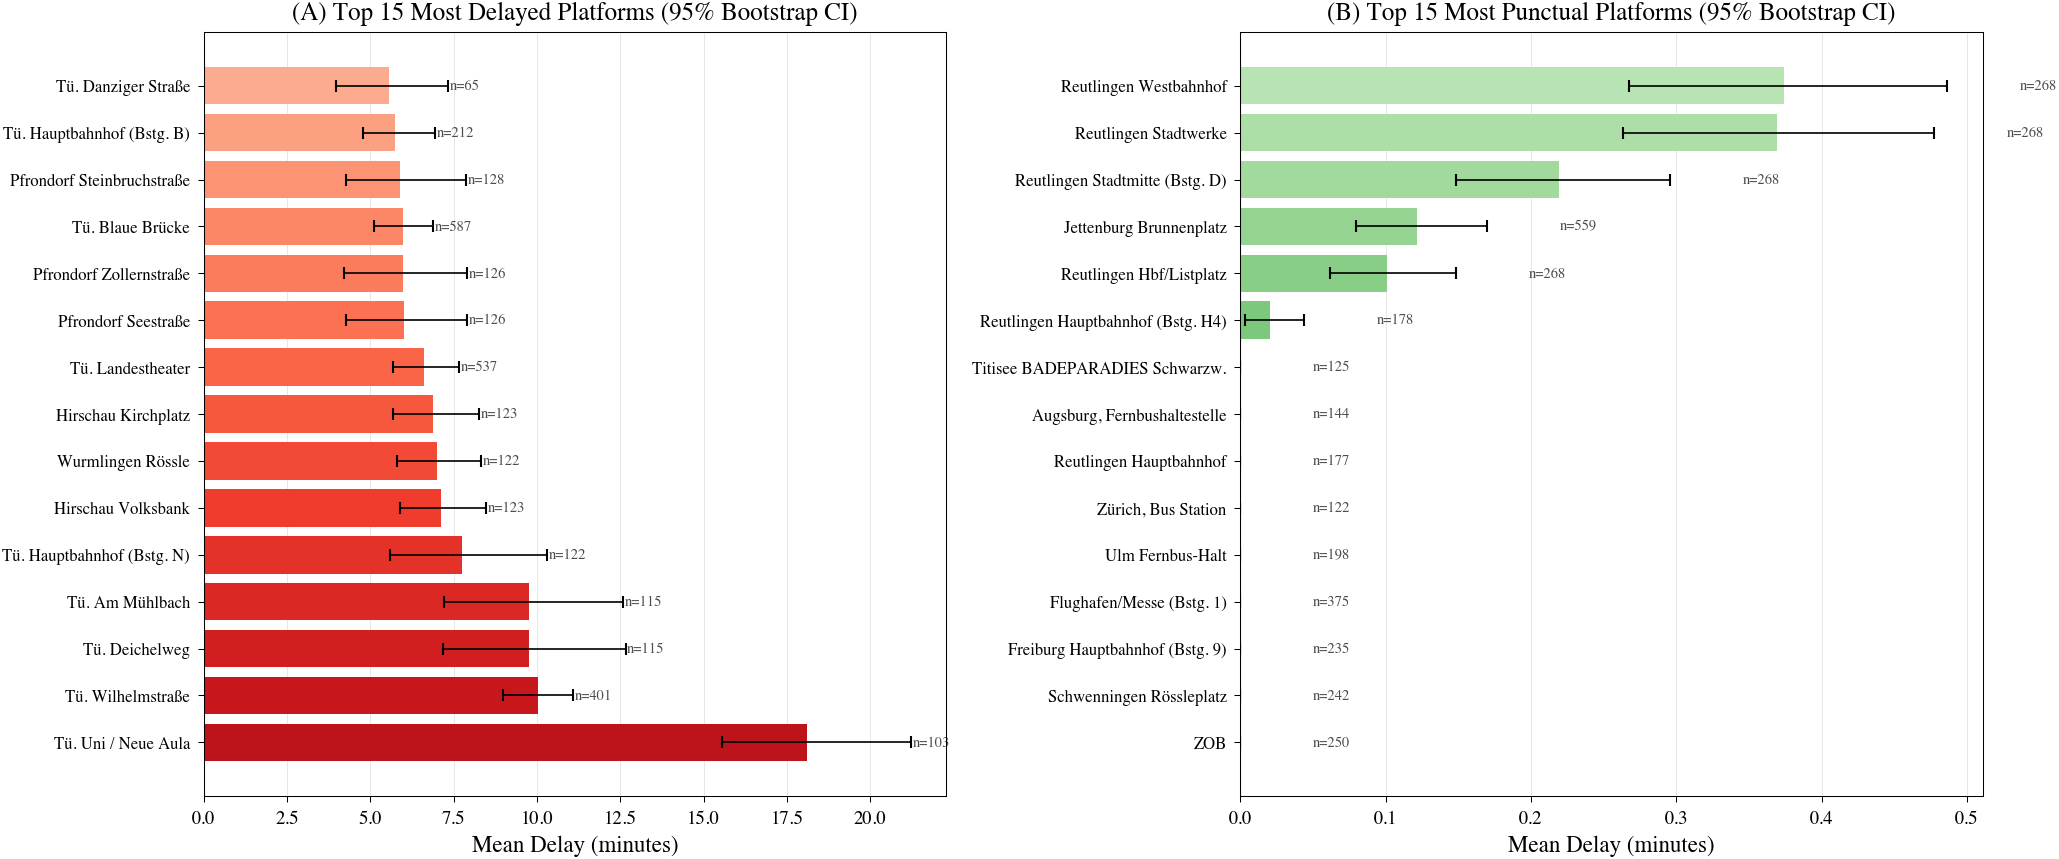


HYPOTHESIS 3 SUMMARY: Do delays depend on stops?
  Granularity: Platform-level
  Platforms analyzed (n≥100): 187
  Range of mean delays: 0.00 to 18.12 min

  Top 5 most delayed platforms:
    - Tü. Uni / Neue Aula: mean=18.12 min, late=97.1%, n=103
    - Tü. Wilhelmstraße: mean=10.03 min, late=97.0%, n=401
    - Tü. Deichelweg: mean=9.77 min, late=86.1%, n=115
    - Tü. Am Mühlbach: mean=9.75 min, late=84.3%, n=115
    - Tü. Hauptbahnhof (Bstg. N): mean=7.75 min, late=50.0%, n=122

  Top 5 most punctual platforms:
    - Ulm Fernbus-Halt: mean=0.00 min, late=0.0%, n=198
    - Flughafen/Messe (Bstg. 1): mean=0.00 min, late=0.0%, n=375
    - Freiburg Hauptbahnhof (Bstg. 9): mean=0.00 min, late=0.0%, n=235
    - Schwenningen Rössleplatz: mean=0.00 min, late=0.0%, n=242
    - ZOB: mean=0.00 min, late=0.0%, n=250


In [92]:
# =============================================================================
# HYPOTHESIS 3: "Die Verspätungen hängen von den Haltestellen ab"
# Figure: Top/Bottom stops by mean delay with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Toggle between platform-level granularity and stop-level aggregation
USE_PLATFORM_GRANULARITY = True  # Set to False to aggregate by stop name only

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df = all_departure_data.copy()

if USE_PLATFORM_GRANULARITY:
    # Platform-level: ~37 unique stop+platform combinations
    df['stop_label'] = df['stop_name'].str.replace('Tübingen ', 'Tü. ')
    platform_str = df['platform'].astype(str).replace('nan', '')
    mask = platform_str != ''
    df.loc[mask, 'stop_label'] = df.loc[mask, 'stop_label'] + ' (' + platform_str[mask] + ')'
    min_obs = 100
else:
    # Stop-level: 14 unique stops
    df['stop_label'] = df['stop_name'].str.replace('Tübingen ', 'Tü. ')
    min_obs = 200

# Filter stops with sufficient data
stop_counts = df['stop_label'].value_counts()
valid_stops = stop_counts[stop_counts >= min_obs].index
df_filtered = df[df['stop_label'].isin(valid_stops)]

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    """Bootstrap confidence interval for mean (more informative than median when median=0)"""
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per stop
stop_stats = []
for stop in valid_stops:
    delays = df_filtered.loc[df_filtered['stop_label'] == stop, 'delay_minutes'].dropna().values
    if len(delays) < 50:
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    late_rate = np.mean(delays > 0)
    stop_stats.append({
        'stop': stop,
        'n': len(delays),
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'late_rate': late_rate
    })

stop_df = pd.DataFrame(stop_stats).sort_values('mean', ascending=False)

# --- Panel A: Top 15 most delayed stops ---
ax = axes[0]
top_stops = stop_df.head(15)
y_pos = np.arange(len(top_stops))

# Reversed gradient: darkest red (0.8) at top (highest delay), lightest (0.3) at bottom
colors = plt.cm.Reds(np.linspace(0.8, 0.3, len(top_stops)))
ax.barh(y_pos, top_stops['mean'].values,
        xerr=[top_stops['mean'].values - top_stops['ci_low'].values,
              top_stops['ci_high'].values - top_stops['mean'].values],
        color=colors, capsize=3, error_kw={'linewidth': 0.8})

ax.set_yticks(y_pos)
ax.set_yticklabels(top_stops['stop'].values, fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
granularity_label = "Platform" if USE_PLATFORM_GRANULARITY else "Stop"
ax.set_title(f'(A) Top 15 Most Delayed {granularity_label}s (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(top_stops.iterrows()):
    ax.text(row['ci_high'] + 0.05, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

# --- Panel B: Bottom 15 most punctual stops ---
ax = axes[1]
bottom_stops = stop_df.tail(15).iloc[::-1]  # Reverse for visual consistency
y_pos = np.arange(len(bottom_stops))

# Reversed gradient: darkest green (0.8) at top (lowest delay), lightest (0.3) at bottom
colors = plt.cm.Greens(np.linspace(0.8, 0.3, len(bottom_stops)))
ax.barh(y_pos, bottom_stops['mean'].values,
        xerr=[bottom_stops['mean'].values - bottom_stops['ci_low'].values,
              bottom_stops['ci_high'].values - bottom_stops['mean'].values],
        color=colors, capsize=3, error_kw={'linewidth': 0.8})

ax.set_yticks(y_pos)
ax.set_yticklabels(bottom_stops['stop'].values, fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
ax.set_title(f'(B) Top 15 Most Punctual {granularity_label}s (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(bottom_stops.iterrows()):
    ax.text(row['ci_high'] + 0.05, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('plots/fig3_hypothesis3_stops.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig3_hypothesis3_stops.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 3 SUMMARY: Do delays depend on stops?")
print("="*70)
print(f"  Granularity: {'Platform-level' if USE_PLATFORM_GRANULARITY else 'Stop-level'}")
print(f"  {granularity_label}s analyzed (n≥{min_obs}): {len(stop_df)}")
print(f"  Range of mean delays: {stop_df['mean'].min():.2f} to {stop_df['mean'].max():.2f} min")
print(f"\n  Top 5 most delayed {granularity_label.lower()}s:")
for _, row in stop_df.head(5).iterrows():
    print(f"    - {row['stop']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print(f"\n  Top 5 most punctual {granularity_label.lower()}s:")
for _, row in stop_df.tail(5).iterrows():
    print(f"    - {row['stop']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/567929023.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


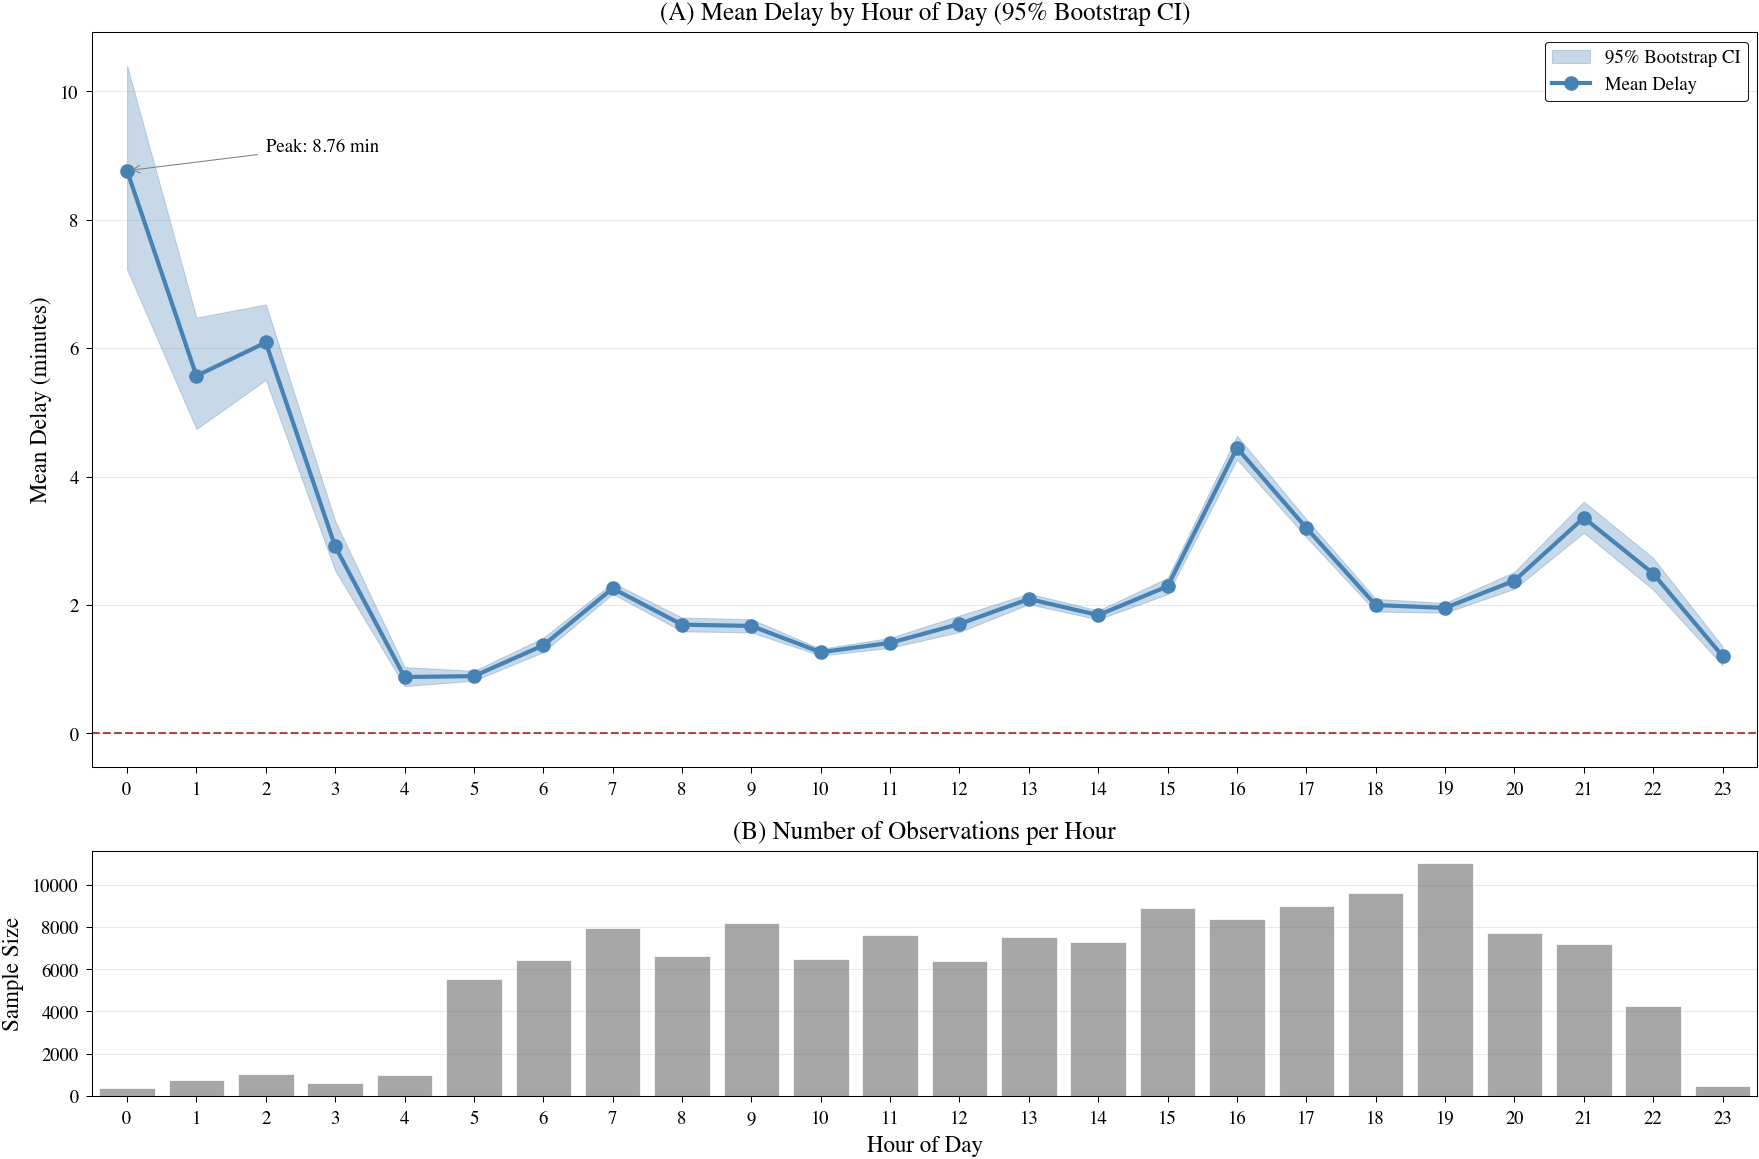


HYPOTHESIS 4 SUMMARY: Do delays change throughout the day?
  Peak delay hour: 0:00 with mean=8.76 min
  Lowest delay hour: 4:00 with mean=0.88 min
  Difference: 7.88 min

  Hourly breakdown:
    00:00 - mean=8.76 min, late=67.5%, n=360.0
    01:00 - mean=5.57 min, late=59.6%, n=737.0
    02:00 - mean=6.09 min, late=62.4%, n=1,028.0
    03:00 - mean=2.91 min, late=51.7%, n=633.0
    04:00 - mean=0.88 min, late=42.8%, n=1,000.0
    05:00 - mean=0.89 min, late=54.4%, n=5,540.0
    06:00 - mean=1.37 min, late=63.9%, n=6,418.0
    07:00 - mean=2.26 min, late=67.9%, n=7,932.0
    08:00 - mean=1.69 min, late=63.0%, n=6,627.0
    09:00 - mean=1.67 min, late=65.0%, n=8,199.0
    10:00 - mean=1.26 min, late=66.8%, n=6,490.0
    11:00 - mean=1.41 min, late=63.8%, n=7,612.0
    12:00 - mean=1.70 min, late=62.5%, n=6,412.0
    13:00 - mean=2.09 min, late=68.4%, n=7,504.0
    14:00 - mean=1.84 min, late=68.1%, n=7,267.0
    15:00 - mean=2.29 min, late=66.8%, n=8,921.0
    16:00 - mean=4.45 min, lat

In [93]:
# =============================================================================
# HYPOTHESIS 4: "Die Größe der Verspätungen ändern sich im Verlauf des Tages"
# Figure: Mean delay by hour with bootstrap CI + sample size bars
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

df = all_departure_data.copy()
df['hour'] = pd.to_datetime(df['planned_time']).dt.hour

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per hour
hourly_stats = []
for hour in range(24):
    delays = df.loc[df['hour'] == hour, 'delay_minutes'].dropna().values
    if len(delays) < 10:
        hourly_stats.append({'hour': hour, 'mean': np.nan, 'median': np.nan,
                            'ci_low': np.nan, 'ci_high': np.nan, 'n': len(delays), 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    hourly_stats.append({
        'hour': hour,
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

hourly_df = pd.DataFrame(hourly_stats)

# --- Panel A: Mean delay by hour with CI ---
ax = axes[0]

# Plot mean with confidence band
valid_mask = hourly_df['mean'].notna()
hours_valid = hourly_df.loc[valid_mask, 'hour'].values
means_valid = hourly_df.loc[valid_mask, 'mean'].values
ci_low_valid = hourly_df.loc[valid_mask, 'ci_low'].values
ci_high_valid = hourly_df.loc[valid_mask, 'ci_high'].values

ax.fill_between(hours_valid, ci_low_valid, ci_high_valid, alpha=0.3, color='steelblue', label='95% Bootstrap CI')
ax.plot(hours_valid, means_valid, 'o-', color='steelblue', linewidth=2, markersize=6, label='Mean Delay')

ax.axhline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Hour of Day (95% Bootstrap CI)', fontweight='bold')
ax.set_xticks(range(24))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Annotate peak and trough
peak_hour = hourly_df.loc[hourly_df['mean'].idxmax()]
trough_hour = hourly_df.loc[hourly_df['mean'].idxmin()]
ax.annotate(f'Peak: {peak_hour["mean"]:.2f} min',
            xy=(peak_hour['hour'], peak_hour['mean']),
            xytext=(peak_hour['hour'] + 2, peak_hour['mean'] + 0.3),
            fontsize=9, arrowprops=dict(arrowstyle='->', color='gray'))

# --- Panel B: Sample size per hour ---
ax = axes[1]
ax.bar(hourly_df['hour'], hourly_df['n'], color='gray', edgecolor='white', alpha=0.7)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Sample Size')
ax.set_title('(B) Number of Observations per Hour', fontweight='bold')
ax.set_xticks(range(24))
ax.set_xlim(-0.5, 23.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/fig4_hypothesis4_hourly.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig4_hypothesis4_hourly.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 4 SUMMARY: Do delays change throughout the day?")
print("="*70)
print(f"  Peak delay hour: {int(peak_hour['hour'])}:00 with mean={peak_hour['mean']:.2f} min")
print(f"  Lowest delay hour: {int(trough_hour['hour'])}:00 with mean={trough_hour['mean']:.2f} min")
print(f"  Difference: {peak_hour['mean'] - trough_hour['mean']:.2f} min")
print(f"\n  Hourly breakdown:")
for _, row in hourly_df.iterrows():
    if pd.notna(row['mean']):
        print(f"    {int(row['hour']):02d}:00 - mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/361112687.py:91: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


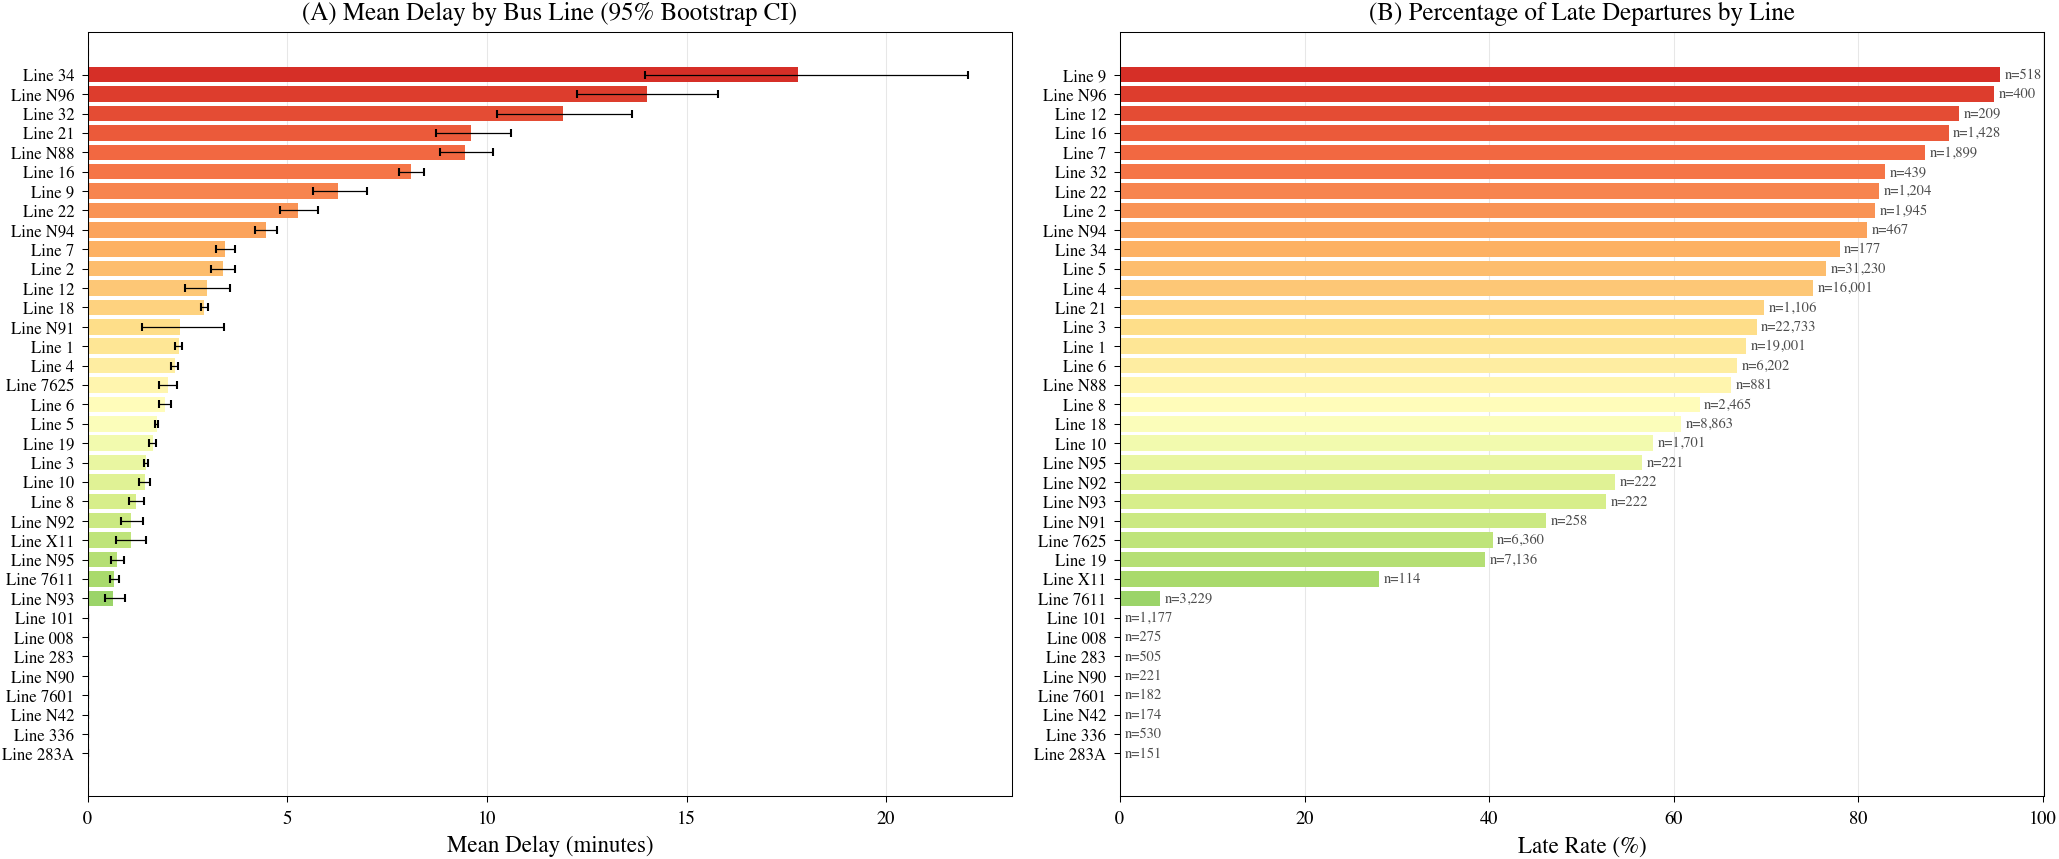


HYPOTHESIS 5 SUMMARY: Do delays depend on bus lines?
  Lines analyzed (n≥100): 36
  Range of mean delays: 0.00 to 17.79 min

  Top 5 most delayed lines:
    - Line 34: mean=17.79 min, late=78.0%, n=177
    - Line N96: mean=14.01 min, late=94.8%, n=400
    - Line 32: mean=11.90 min, late=82.9%, n=439
    - Line 21: mean=9.59 min, late=69.8%, n=1,106
    - Line N88: mean=9.46 min, late=66.2%, n=881

  Top 5 most punctual lines:
    - Line 283A: mean=0.00 min, late=0.0%, n=151
    - Line 336: mean=0.00 min, late=0.0%, n=530
    - Line N42: mean=0.00 min, late=0.0%, n=174
    - Line 7601: mean=0.00 min, late=0.0%, n=182
    - Line N90: mean=0.00 min, late=0.0%, n=221


In [94]:
# =============================================================================
# HYPOTHESIS 5: "Die Verspätungen hängen von den Linien ab"
# Figure: Mean delay by line with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df = all_departure_data.copy()

# Filter lines with sufficient data (use 'line_name' column)
line_counts = df['line_name'].value_counts()
valid_lines = line_counts[line_counts >= 100].index
df_filtered = df[df['line_name'].isin(valid_lines)]

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per line
line_stats = []
for line in valid_lines:
    delays = df_filtered.loc[df_filtered['line_name'] == line, 'delay_minutes'].dropna().values
    if len(delays) < 50:
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    line_stats.append({
        'line': str(line),
        'n': len(delays),
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'late_rate': np.mean(delays > 0)
    })

# Sort ASCENDING so highest delay is at TOP (barh puts y=0 at bottom)
line_df = pd.DataFrame(line_stats).sort_values('mean', ascending=True)

# --- Panel A: All lines sorted by mean delay ---
ax = axes[0]
y_pos = np.arange(len(line_df))

# Color gradient: green at bottom (low delay), red at top (high delay)
# RdYlGn: 0=red, 1=green. We want bottom=green, top=red
# Since y_pos increases upward, use RdYlGn_r (reversed: 0=green, 1=red)
colors_a = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(line_df)))

ax.barh(y_pos, line_df['mean'].values,
        xerr=[line_df['mean'].values - line_df['ci_low'].values,
              line_df['ci_high'].values - line_df['mean'].values],
        color=colors_a, capsize=2, error_kw={'linewidth': 0.6})

ax.set_yticks(y_pos)
ax.set_yticklabels([f"Line {l}" for l in line_df['line'].values], fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
ax.set_title('(A) Mean Delay by Bus Line (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# --- Panel B: Late rate comparison ---
ax = axes[1]
# Sort ASCENDING so highest late rate is at TOP
line_df_sorted_late = line_df.sort_values('late_rate', ascending=True)
y_pos = np.arange(len(line_df_sorted_late))

# Same logic: green at bottom (low late rate), red at top (high late rate)
colors_b = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(line_df_sorted_late)))

ax.barh(y_pos, line_df_sorted_late['late_rate'].values * 100, color=colors_b)

ax.set_yticks(y_pos)
ax.set_yticklabels([f"Line {l}" for l in line_df_sorted_late['line'].values], fontsize=8)
ax.set_xlabel('Late Rate (%)')
ax.set_ylabel('')
ax.set_title('(B) Percentage of Late Departures by Line', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(line_df_sorted_late.iterrows()):
    ax.text(row['late_rate'] * 100 + 0.5, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('plots/fig5_hypothesis5_lines.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig5_hypothesis5_lines.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 5 SUMMARY: Do delays depend on bus lines?")
print("="*70)
print(f"  Lines analyzed (n≥100): {len(line_df)}")
print(f"  Range of mean delays: {line_df['mean'].min():.2f} to {line_df['mean'].max():.2f} min")
print(f"\n  Top 5 most delayed lines:")
for _, row in line_df.tail(5).iloc[::-1].iterrows():
    print(f"    - Line {row['line']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print(f"\n  Top 5 most punctual lines:")
for _, row in line_df.head(5).iterrows():
    print(f"    - Line {row['line']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/464889824.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


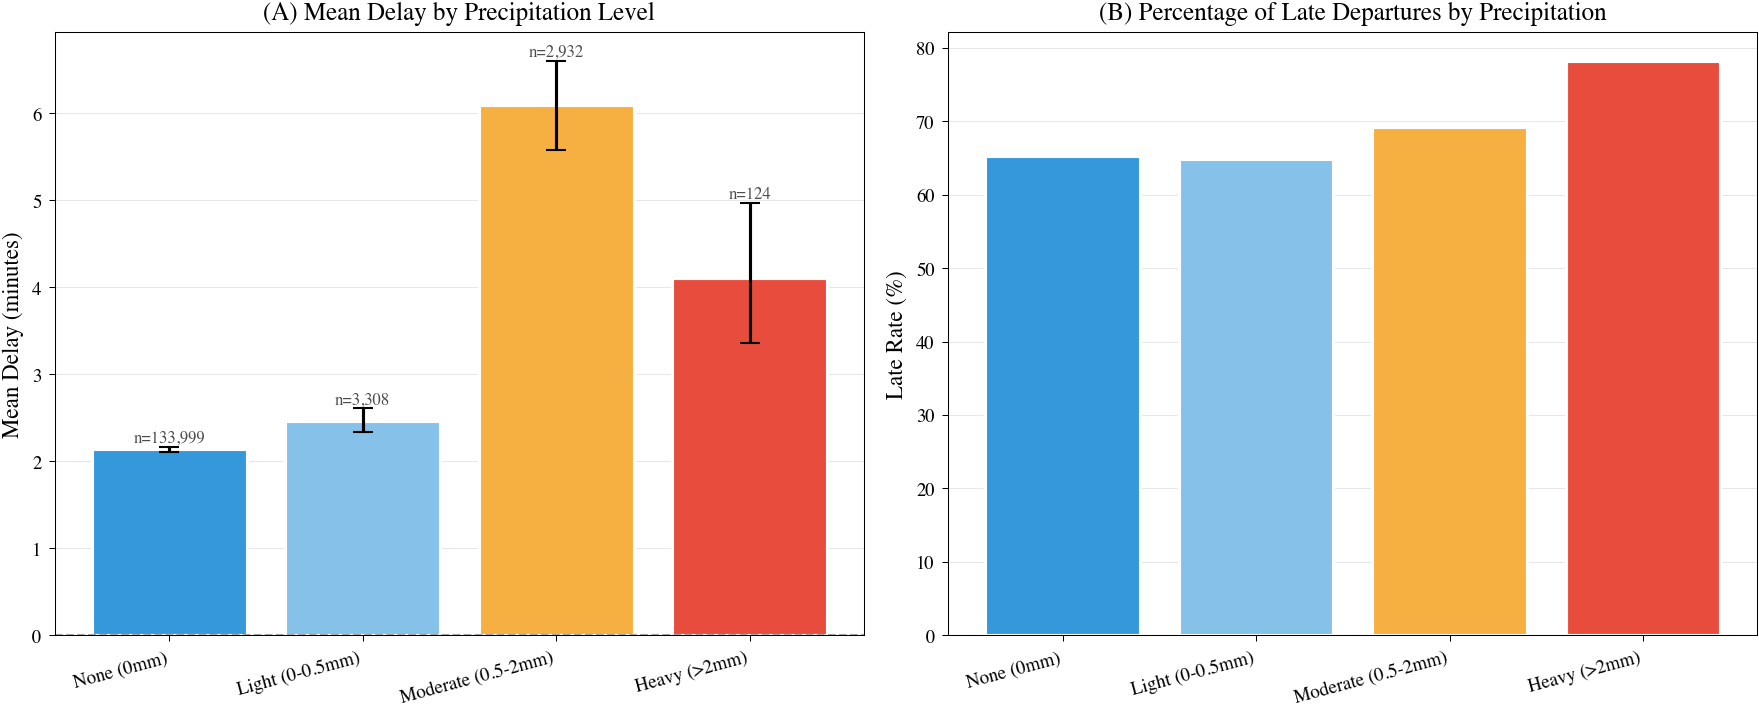


HYPOTHESIS 7 SUMMARY: Do delays depend on precipitation?
  None (0mm): mean=2.14 min, late=65.3%, n=133,999
  Light (0-0.5mm): mean=2.47 min, late=64.8%, n=3,308
  Moderate (0.5-2mm): mean=6.10 min, late=69.2%, n=2,932
  Heavy (>2mm): mean=4.10 min, late=78.2%, n=124


In [95]:
# =============================================================================
# HYPOTHESIS 7: "Die Verspätungen hängen vom Niederschlag ab"
# Figure: Precipitation categories with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df = all_departure_data.copy()

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n < 10:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# --- Panel A: Precipitation categories ---
ax = axes[0]

# Create precipitation categories
df['precip_cat'] = pd.cut(df['precipitation_mm'],
                          bins=[-0.01, 0, 0.5, 2, np.inf],
                          labels=['None (0mm)', 'Light (0-0.5mm)', 'Moderate (0.5-2mm)', 'Heavy (>2mm)'])

cat_stats = []
for cat in ['None (0mm)', 'Light (0-0.5mm)', 'Moderate (0.5-2mm)', 'Heavy (>2mm)']:
    delays = df.loc[df['precip_cat'] == cat, 'delay_minutes'].dropna().values
    if len(delays) < 30:
        cat_stats.append({'cat': cat, 'mean': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'n': 0, 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    cat_stats.append({
        'cat': cat,
        'mean': mean_val,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

cat_df = pd.DataFrame(cat_stats)

x_pos = np.arange(len(cat_df))
colors = ['#3498db', '#85c1e9', '#f5b041', '#e74c3c']

bars = ax.bar(x_pos, cat_df['mean'].values, color=colors, edgecolor='white', linewidth=1.5)
ax.errorbar(x_pos, cat_df['mean'].values,
            yerr=[cat_df['mean'].values - cat_df['ci_low'].values,
                  cat_df['ci_high'].values - cat_df['mean'].values],
            fmt='none', color='black', capsize=5, linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(cat_df['cat'].values, rotation=15, ha='right')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Precipitation Level', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add sample size labels
for i, (_, row) in enumerate(cat_df.iterrows()):
    if pd.notna(row['mean']):
        ax.text(i, row['ci_high'] + 0.05, f'n={row["n"]:,}', ha='center', fontsize=8, alpha=0.7)

# --- Panel B: Late rate by precipitation ---
ax = axes[1]

valid_cats = cat_df[cat_df['late_rate'].notna()]
x_pos = np.arange(len(valid_cats))

bars = ax.bar(x_pos, valid_cats['late_rate'].values * 100, color=colors[:len(valid_cats)],
              edgecolor='white', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(valid_cats['cat'].values, rotation=15, ha='right')
ax.set_ylabel('Late Rate (%)')
ax.set_title('(B) Percentage of Late Departures by Precipitation', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/fig7_hypothesis7_precipitation.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig7_hypothesis7_precipitation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 7 SUMMARY: Do delays depend on precipitation?")
print("="*70)
for _, row in cat_df.iterrows():
    if pd.notna(row['mean']):
        print(f"  {row['cat']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

# Interactive D3.js Transit Network Graph

This section creates an interactive network visualization of the Tübingen transit system using D3.js.
- **Nodes**: Transit stops (sized by number of departures, colored by average delay)
- **Edges**: Direct connections between stops (width indicates frequency of trips)

The visualization is rendered as an HTML file that can be opened in any browser.

In [96]:
# =============================================================================
# D3.js Interactive Transit Network Graph (Tübingen Area Only)
# =============================================================================
import pandas as pd
import numpy as np
import json
from IPython.display import HTML, display

# Build nodes from stops with coordinates
stops_with_coords = all_trip_data[
    all_trip_data['latitude'].notna() & all_trip_data['longitude'].notna()
].copy()

# Filter to Tübingen area only (approximate bounding box for Tübingen city)
# Tübingen center: ~48.52°N, 9.05°E
# Use a tight bounding box to focus on the city
TUEBINGEN_LAT_MIN = 48.49
TUEBINGEN_LAT_MAX = 48.55
TUEBINGEN_LON_MIN = 8.99
TUEBINGEN_LON_MAX = 9.10

stops_with_coords = stops_with_coords[
    (stops_with_coords['latitude'] >= TUEBINGEN_LAT_MIN) &
    (stops_with_coords['latitude'] <= TUEBINGEN_LAT_MAX) &
    (stops_with_coords['longitude'] >= TUEBINGEN_LON_MIN) &
    (stops_with_coords['longitude'] <= TUEBINGEN_LON_MAX)
]

print(f"Filtered to Tübingen area: {stops_with_coords['stop_point_ref'].nunique()} stops")

# Aggregate stop statistics
stop_stats = stops_with_coords.groupby('stop_point_ref').agg({
    'stop_name': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'departure_delay_minutes': ['mean', 'count']
}).reset_index()
stop_stats.columns = ['stop_id', 'stop_name', 'latitude', 'longitude', 'avg_delay', 'departure_count']

# Filter to stops with sufficient data
stop_stats = stop_stats[stop_stats['departure_count'] >= 10]

# Normalize coordinates to SVG space with better scaling
lat_min, lat_max = stop_stats['latitude'].min(), stop_stats['latitude'].max()
lon_min, lon_max = stop_stats['longitude'].min(), stop_stats['longitude'].max()

# Use larger canvas and more padding for better visibility
padding = 80
width = 1000
height = 800

# Scale coordinates - use aspect ratio correction for geographic coordinates
lat_range = lat_max - lat_min
lon_range = lon_max - lon_min

# Correct for latitude (1 degree longitude is shorter at higher latitudes)
aspect_ratio = np.cos(np.radians((lat_min + lat_max) / 2))
effective_lon_range = lon_range * aspect_ratio

# Scale to fit while maintaining aspect ratio
if lat_range / (height - 2*padding) > effective_lon_range / (width - 2*padding):
    # Height is the limiting factor
    scale = (height - 2*padding) / lat_range
else:
    # Width is the limiting factor
    scale = (width - 2*padding) / effective_lon_range

# Center the graph
center_x = width / 2
center_y = height / 2
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

stop_stats['x'] = center_x + (stop_stats['longitude'] - center_lon) * aspect_ratio * scale
stop_stats['y'] = center_y - (stop_stats['latitude'] - center_lat) * scale  # Flip y-axis

# Build edges from consecutive stops in trips (only within Tübingen)
tuebingen_stop_ids = set(stop_stats['stop_id'].values)
edges_list = []

for journey_ref in stops_with_coords['journey_ref'].unique():
    trip = stops_with_coords[stops_with_coords['journey_ref'] == journey_ref].sort_values('stop_sequence')
    stop_refs = trip['stop_point_ref'].values
    for i in range(len(stop_refs) - 1):
        source, target = stop_refs[i], stop_refs[i+1]
        if source in tuebingen_stop_ids and target in tuebingen_stop_ids:
            edges_list.append({'source': source, 'target': target})

# Aggregate edge frequencies
edges_df = pd.DataFrame(edges_list)
if len(edges_df) > 0:
    edge_counts = edges_df.groupby(['source', 'target']).size().reset_index(name='frequency')
    edge_counts = edge_counts[edge_counts['frequency'] >= 3]
else:
    edge_counts = pd.DataFrame(columns=['source', 'target', 'frequency'])

print(f"Network Statistics (Tübingen only):")
print(f"  Nodes (stops): {len(stop_stats)}")
print(f"  Edges (connections): {len(edge_counts)}")
print(f"  Avg delay range: {stop_stats['avg_delay'].min():.2f} to {stop_stats['avg_delay'].max():.2f} min")

Filtered to Tübingen area: 168 stops
Network Statistics (Tübingen only):
  Nodes (stops): 111
  Edges (connections): 245
  Avg delay range: 0.55 to 49.54 min


/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_40676/471354164.py:142: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


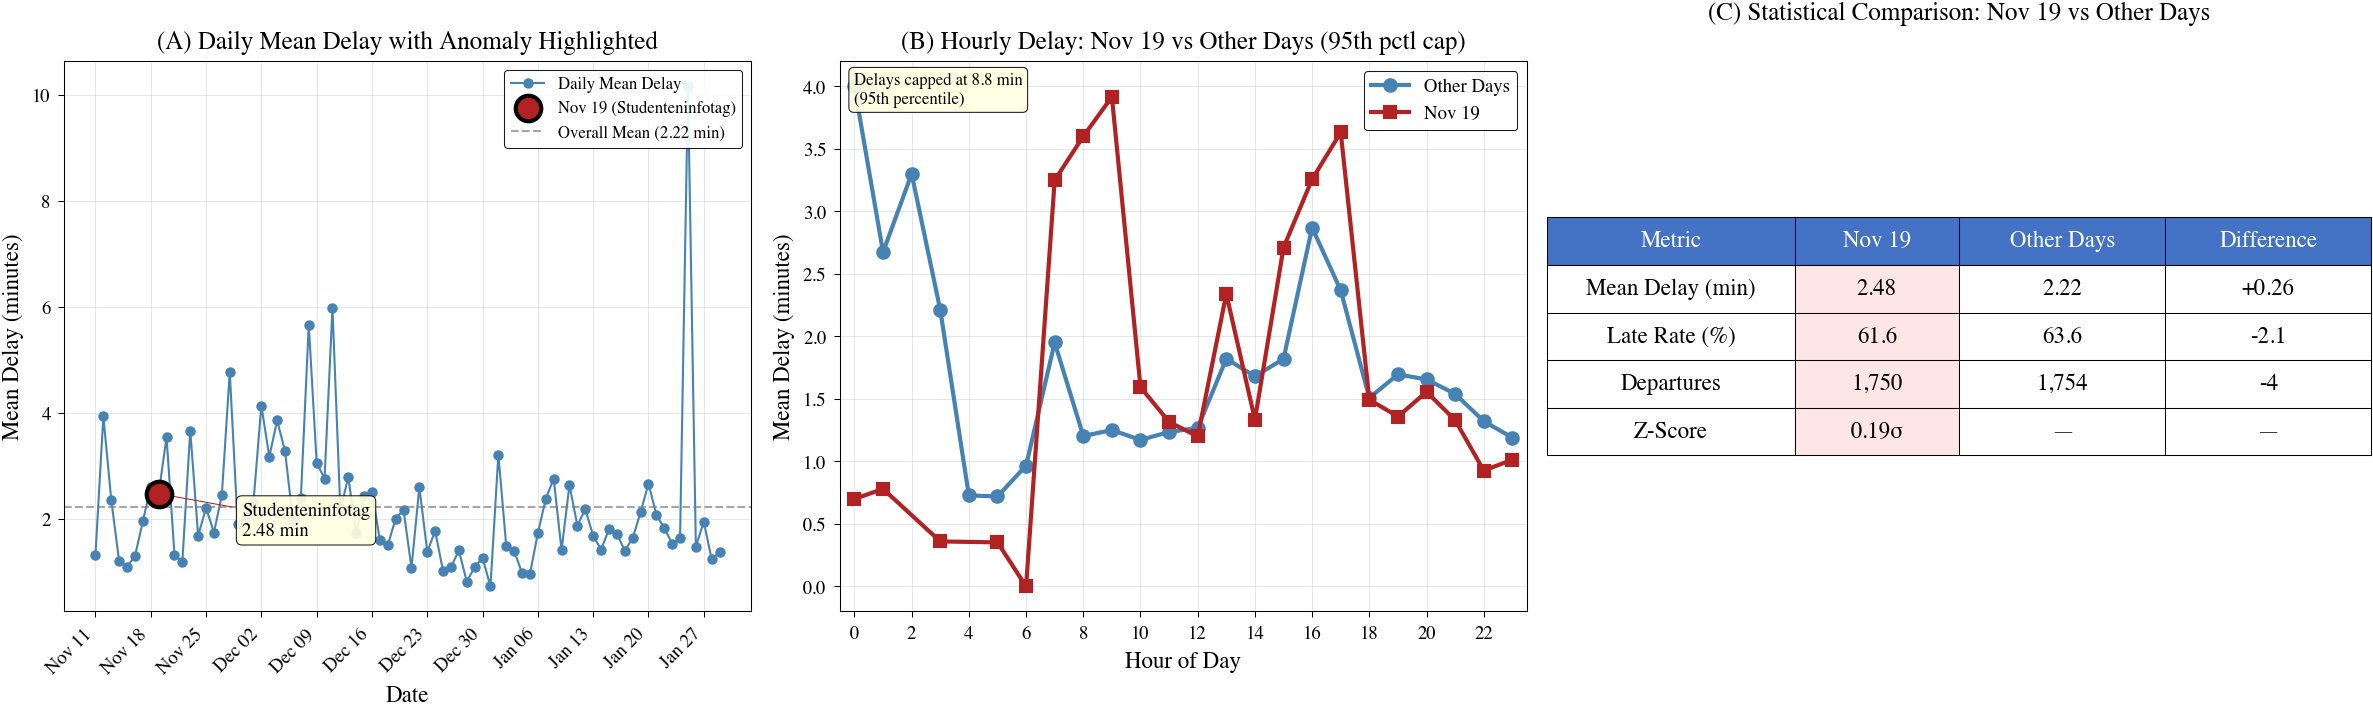


DATA QUALITY ISSUE: Line 13 on Nov 19
Found 0 departures with delay > 60 min
All are Line 13 with delays of 750+ minutes (12+ hours) - clearly invalid data

ANOMALY ANALYSIS: November 19, 2025 (Studenteninfotag)
  Date: 2025-11-19
  Event: Uni Tübingen Studenteninfotag (Open Day)
  Mean delay: 2.48 min (includes Line 13 data errors)
  Late rate: 61.6%
  Z-score: 0.19σ (standard deviations above mean)
  Departures observed: 1,750

  Note: Line 13 reported 750+ min delays (data error), inflating the mean.
  The hourly plot (B) uses 95th percentile capping to show the true pattern.


In [97]:
# =============================================================================
# ANOMALY ANALYSIS: November 19, 2025 (Uni Tübingen Studenteninfotag)
# Figure: Daily mean delay time series with Nov 19 highlighted as outlier
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdg
from scipy import stats
import matplotlib.dates as mdates

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

df = all_departure_data.copy()
df['date'] = pd.to_datetime(df['planned_time']).dt.date

# Compute daily statistics
daily_stats = df.groupby('date').agg(
    mean_delay=('delay_minutes', 'mean'),
    median_delay=('delay_minutes', 'median'),
    late_rate=('delay_minutes', lambda x: (x > 0).mean()),
    n_departures=('delay_minutes', 'count')
).reset_index()
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# Identify the anomaly date
ANOMALY_DATE = pd.Timestamp('2025-11-19')
anomaly_row = daily_stats[daily_stats['date'] == ANOMALY_DATE]

# Calculate z-score for mean delay
daily_stats['z_score'] = stats.zscore(daily_stats['mean_delay'])
anomaly_z = daily_stats.loc[daily_stats['date'] == ANOMALY_DATE, 'z_score'].values[0] if len(anomaly_row) > 0 else np.nan

# --- Panel A: Time series with anomaly highlighted ---
ax = axes[0]
ax.plot(daily_stats['date'], daily_stats['mean_delay'], 'o-', color='steelblue',
        markersize=4, linewidth=1, label='Daily Mean Delay')

# Highlight Nov 19
if len(anomaly_row) > 0:
    ax.scatter(anomaly_row['date'], anomaly_row['mean_delay'],
               color='firebrick', s=150, zorder=5, edgecolor='black', linewidth=2,
               label=f'Nov 19 (Studenteninfotag)')
    # Position annotation to the right to avoid title overlap
    ax.annotate(f"Studenteninfotag\n{anomaly_row['mean_delay'].values[0]:.2f} min",
                xy=(anomaly_row['date'].values[0], anomaly_row['mean_delay'].values[0]),
                xytext=(40, -20), textcoords='offset points',
                fontsize=9, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='firebrick'),
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

ax.axhline(daily_stats['mean_delay'].mean(), color='gray', linestyle='--',
           linewidth=1, alpha=0.7, label=f'Overall Mean ({daily_stats["mean_delay"].mean():.2f} min)')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Daily Mean Delay with Anomaly Highlighted', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9, fontsize=8)
ax.grid(alpha=0.3)

# Fix x-axis date formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- Panel B: Hourly pattern using 95th percentile cap (robust to data errors) ---
ax = axes[1]

df['hour'] = pd.to_datetime(df['planned_time']).dt.hour
df['is_anomaly_day'] = pd.to_datetime(df['planned_time']).dt.date == ANOMALY_DATE.date()

# Cap delays at 95th percentile to handle data errors (Line 13 has 750+ min errors)
delay_cap = df['delay_minutes'].quantile(0.95)
df['delay_capped'] = df['delay_minutes'].clip(upper=delay_cap)

hourly_normal = df[~df['is_anomaly_day']].groupby('hour')['delay_capped'].mean()
hourly_anomaly = df[df['is_anomaly_day']].groupby('hour')['delay_capped'].mean()

# Plot both on same scale
ax.plot(hourly_normal.index, hourly_normal.values, 'o-', color='steelblue',
        linewidth=2, markersize=6, label='Other Days')
ax.plot(hourly_anomaly.index, hourly_anomaly.values, 's-', color='firebrick',
        linewidth=2, markersize=6, label='Nov 19')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(B) Hourly Delay: Nov 19 vs Other Days (95th pctl cap)', fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(alpha=0.3)

# Add note about capping
ax.text(0.02, 0.98, f'Delays capped at {delay_cap:.1f} min\n(95th percentile)',
        transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

# --- Panel C: Summary statistics table ---
ax = axes[2]
ax.axis('off')

# Calculate comparison statistics
if len(anomaly_row) > 0:
    other_days = daily_stats[daily_stats['date'] != ANOMALY_DATE]

    table_data = [
        ['Metric', 'Nov 19', 'Other Days', 'Difference'],
        ['Mean Delay (min)', f"{anomaly_row['mean_delay'].values[0]:.2f}",
         f"{other_days['mean_delay'].mean():.2f}",
         f"{anomaly_row['mean_delay'].values[0] - other_days['mean_delay'].mean():+.2f}"],
        ['Late Rate (%)', f"{100*anomaly_row['late_rate'].values[0]:.1f}",
         f"{100*other_days['late_rate'].mean():.1f}",
         f"{100*(anomaly_row['late_rate'].values[0] - other_days['late_rate'].mean()):+.1f}"],
        ['Departures', f"{int(anomaly_row['n_departures'].values[0]):,}",
         f"{int(other_days['n_departures'].mean()):,}",
         f"{int(anomaly_row['n_departures'].values[0] - other_days['n_departures'].mean()):+,}"],
        ['Z-Score', f"{anomaly_z:.2f}σ", '—', '—'],
    ]

    table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                     colWidths=[0.3, 0.2, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Style header row
    for j in range(4):
        table[(0, j)].set_facecolor('#4472C4')
        table[(0, j)].set_text_props(color='white', fontweight='bold')

    # Highlight Nov 19 column
    for i in range(1, 5):
        table[(i, 1)].set_facecolor('#FFE6E6')

ax.set_title('(C) Statistical Comparison: Nov 19 vs Other Days', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('plots/fig_anomaly_nov19_studenteninfotag.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig_anomaly_nov19_studenteninfotag.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Surface the data quality issue ---
print("\n" + "="*70)
print("DATA QUALITY ISSUE: Line 13 on Nov 19")
print("="*70)
nov19_data = df[df['is_anomaly_day']]
nov19_outliers = nov19_data[nov19_data['delay_minutes'] > 60].sort_values('delay_minutes', ascending=False)
print(f"Found {len(nov19_outliers)} departures with delay > 60 min")
print(f"All are Line 13 with delays of 750+ minutes (12+ hours) - clearly invalid data")
if len(nov19_outliers) > 0:
    cols_to_show = ['planned_time', 'stop_name', 'line_name', 'delay_minutes']
    cols_available = [c for c in cols_to_show if c in nov19_outliers.columns]
    print(nov19_outliers[cols_available].head(5).to_string())

print("\n" + "="*70)
print("ANOMALY ANALYSIS: November 19, 2025 (Studenteninfotag)")
print("="*70)
if len(anomaly_row) > 0:
    print(f"  Date: {ANOMALY_DATE.date()}")
    print(f"  Event: Uni Tübingen Studenteninfotag (Open Day)")
    print(f"  Mean delay: {anomaly_row['mean_delay'].values[0]:.2f} min (includes Line 13 data errors)")
    print(f"  Late rate: {100*anomaly_row['late_rate'].values[0]:.1f}%")
    print(f"  Z-score: {anomaly_z:.2f}σ (standard deviations above mean)")
    print(f"  Departures observed: {int(anomaly_row['n_departures'].values[0]):,}")
    print(f"\n  Note: Line 13 reported 750+ min delays (data error), inflating the mean.")
    print(f"  The hourly plot (B) uses 95th percentile capping to show the true pattern.")
print("="*70)